In [1]:
import os
import pandas as pd
import numpy as np
import re
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px #графики в 3D

from scipy import stats
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

from  more_itertools import unique_everseen
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Гипотезы:  
1) Показатель Global Innovation Index коррелирует с Gross Natural Income (GNI). Будем считать наличие кореляции, если pvalue теста Mann–Whitney буде менее 0.05.  
2) Gross Natural Income (GNI) коррелирует с показателями государственной поддержкой экономики. Будем считать наличие кореляции, если pvalue теста Mann–Whitney будет < __0.05__.

### Диверсированные показателями государственной поддержкой экономики:

Я выбрал 37 показателей, которые могут характеризовать государственную поддержку и 5 интегральных позателей:

___1.1.	Political environment (интегральный покозатель)___  
1.1.1.	Political stability and absence of violence/terrorism  
1.1.2.	Government effectiveness  
1.1.3.	Press freedom  

___1.2.	Regulatory environment (интегральный покозатель)___  
1.2.1.	Regulatory quality  
1.2.2.	Rule of law  
1.2.3.	Cost of redundancy dismissal  

___1.3.	Business environment (интегральный покозатель)___  
1.3.1.	Ease of starting a business  
1.3.2.	Ease of resolving insolvency  
1.3.3.	Ease of paying taxes  

2.1.1.	Expenditure on education  
2.1.2.	Public expenditure on education per pupil  

2.1.5.	Pupil-teacher ratio, secondary  

2.2.1.	Tertiary enrolment  
2.2.2.	Graduates in science and engineering  

2.3.1.	Researchers  
2.3.2.	Gross expenditure on R&D (GERD)  

3.1.3.	Government's online service  

3.2.1.	Electricity output  
3.2.3.	Logistics performance  

3.3.2.	Environmental performance  


___4.1.	Credit (интегральный покозатель)___  
4.1.1.	Ease of getting credit  
4.1.2.	Domestic credit to private sector  
4.1.3.	Microfinance institutions' gross loan portfolio  

4.2.1.	Ease of protecting investors  

4.2.4.	Venture capital deals  

4.3.2.	Market access for non-agricultural exports  
4.3.3.	Intensity of local competition  

5.1.2.	Firms offering formal training  

___5.2.	Innovation linkages (интегральный покозатель)___   
5.2.1.	University/industry research collaboration  
5.2.2.	State of cluster development  
5.2.3.	GERD financed by abroad  
5.2.4.	Joint venture/strategic alliance deals  
5.2.5.	Patent families filed in at least three offices  

5.3.1.	Royalties and license fees payments (% of service imports)  
5.3.4.	Foreign direct investment net inflows  

6.1.2.	Patent Cooperation Treaty resident applications  

6.3.4.	Foreign direct investment net outflows

### Интегральные показатели
1.1 Political environment  
1.2 Regulatory environment  
1.3 Business environment  
4.1 Credit  
5.2 Innovation linkages

# Исследование датасета

Построить графики:  
1) индекс GII по годам и регионам - кластеризация  
2) индекс GII по годам  
3) интегральные признаки по регионам  

In [2]:
#загружаю датасет из файла
with open("C://Users//dserp//ML//Degree_ML//dataset_GW.pickle", 'rb') as f:
    dataset = pickle.load(f)
f.close()

In [3]:
dataset['GII'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 2013 to region
Columns: 143 entries, Albania to Seychelles
dtypes: float64(68), object(75)
memory usage: 9.0+ KB


In [4]:
dataset['GII'].T.describe()

2013   2014   2015   2016   2017   2018   2019        region
count   143.0  143.0  143.0  143.0  143.0  143.0  143.0            75
unique  141.0  139.0  139.0  138.0  138.0  138.0  138.0            19
top      51.0  102.0  102.0  102.0  101.0  101.0  122.0  Western Asia
freq      2.0    2.0    2.0    2.0    2.0    2.0    2.0             8

In [5]:
dataset['2019'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 7 to 95
Columns: 129 entries, 2019 to Zimbabwe
dtypes: float64(127), object(2)
memory usage: 35.5+ KB


## Индекс GII по годам и регионам

In [6]:
range_country = dataset['region']['region'].value_counts()
print(' Всего стран:',len(dataset['region'].index),  'В', len(range_country.index), 'регионах')

 Всего стран: 204 В 22 регионах


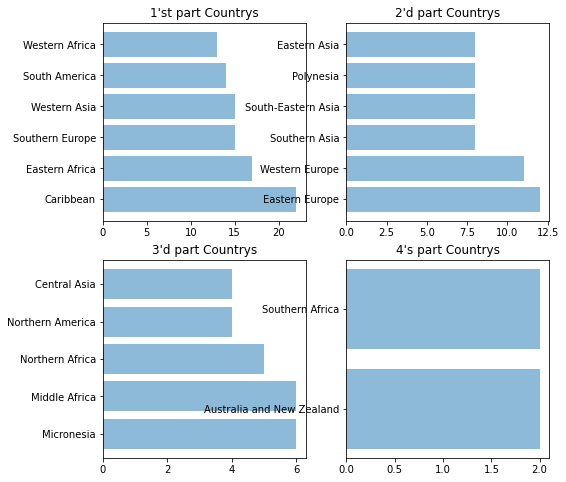

In [7]:
gridsize = (2, 2)
fig1, ax1 = plt.subplots(2,2, figsize = [8,8])
ax1 = ax1.flatten()

ax1[0] = plt.subplot2grid(gridsize, (0, 0))
ax1[0].barh(range_country.index[0:6], dataset['region']['region'].value_counts()[0:6], align='center', alpha=0.5)
ax1[0].set_title("1'st part Countrys")

ax1[1] = plt.subplot2grid(gridsize, (0, 1))
ax1[1].barh(range_country.index[7:13], dataset['region']['region'].value_counts()[7:13], align='center', alpha=0.5)
ax1[1].set_title("2'd part Countrys")

ax1[2] = plt.subplot2grid(gridsize, (1, 0))
ax1[2].barh(range_country.index[14:19], dataset['region']['region'].value_counts()[14:19], align='center', alpha=0.5)
ax1[2].set_title("3'd part Countrys")

ax1[3] = plt.subplot2grid(gridsize, (1, 1))
ax1[3].barh(range_country.index[20:22], dataset['region']['region'].value_counts()[20:22], align='center', alpha=0.5)
ax1[3].set_title("4's part Countrys")

plt.show()

In [8]:
#подсчёт количества стран
reg_count = {}
reg_count = dataset['GII'].iloc[[7]].T['region'].value_counts()[:22]
reg_count

Western Asia                 8
Southern Europe              7
Northern Europe              7
South America                6
Western Africa               6
Eastern Europe               5
Central America              5
Eastern Asia                 5
Western Europe               5
Eastern Africa               5
Southern Asia                3
South-Eastern Asia           3
Northern Africa              2
Central Asia                 2
Caribbean                    2
Northern America             1
Middle Africa                1
Southern Africa              1
Australia and New Zealand    1
Name: region, dtype: int64

In [9]:
#создаю датафрам с суммой gii по регионама и годам
ds_gii_sum = dataset['GII'].iloc[[0,7], :].T.groupby('region').sum().reset_index()
for i  in range(1,7):
    ds_gii_sum = ds_gii_sum.merge(dataset['GII'].iloc[[i,7], :].T.groupby('region').sum().reset_index(), how = 'left')
ds_gii_sum.fillna(0, inplace = True)
ds_gii_sum = ds_gii_sum.iloc[:22]
ds_gii_sum = ds_gii_sum.rename(index = ds_gii_sum['region'])
ds_gii_sum.drop('region', axis = 1, inplace = True)
ds_gii_sum.drop(2019, axis = 1, inplace = True)

#усреднение gii на 1 страну в реионе
for reg in ds_gii_sum.index:
    ds_gii_sum.loc[reg] /= reg_count[reg]
ds_gii_sum

2013        2014        2015        2016  \
Australia and New Zealand   19.000000   17.000000   17.000000   19.000000   
Caribbean                   80.500000   82.500000   92.500000   82.500000   
Central America             76.800000   87.400000   84.200000   81.600000   
Central Asia               100.500000   95.500000   95.500000   89.000000   
Eastern Africa             108.000000   97.600000   98.200000   90.400000   
Eastern Asia                30.800000   26.400000   27.800000   24.200000   
Eastern Europe              44.400000   41.200000   39.000000   44.600000   
Middle Africa              125.000000  114.000000  110.000000  118.000000   
Northern Africa            123.000000  116.000000  113.000000  110.000000   
Northern America            11.000000   12.000000   16.000000   15.000000   
Northern Europe             19.428571   19.857143   18.714286   18.142857   
South America               67.333333   78.500000   79.000000   77.666667   
South-Eastern Asia          75.666667   75.333333   73.333333   72.666667   
Southern Africa             91.000000   92.000000   90.000000   90.000000   
Southern Asia              103.000000  108.333333  105.333333   87.000000   
Southern Europe             47.142857   50.428571   48.857143   50.285714   
Western Africa             117.500000  118.500000  116.583333  115.333333   
Western Asia                63.000000   65.875000   66.750000   63.250000   
Western Europe              18.200000   17.400000   17.000000   16.600000   

                                 2017        2018  
Australia and New Zealand   23.000000   20.000000  
Caribbean                   81.500000   84.000000  
Central America             83.200000   84.200000  
Central Asia                86.500000   84.000000  
Eastern Africa              96.000000   98.680000  
Eastern Asia                23.000000   21.800000  
Eastern Europe              48.200000   46.200000  
Middle Africa              117.000000  111.000000  
Northern Africa            106.500000  102.500000  
Northern America            18.000000   18.000000  
Northern Europe             19.285714   20.857143  
South America               75.666667   78.000000  
South-Eastern Asia          75.000000   72.666667  
Southern Africa             89.000000   91.000000  
Southern Asia               83.000000   79.333333  
Southern Europe             49.857143   47.000000  
Western Africa             115.333333  117.666667  
Western Asia                64.000000   65.125000  
Western Europe              16.600000   17.200000

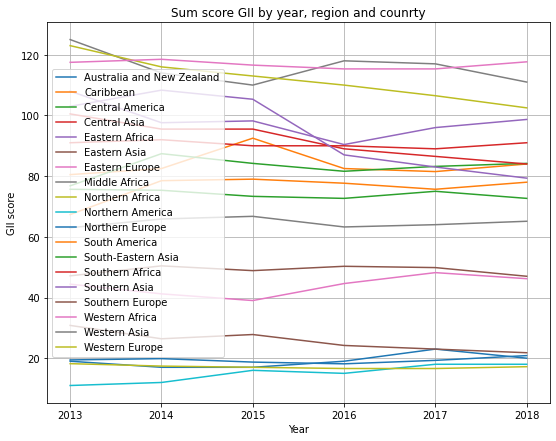

In [10]:
plt.figure(figsize = [9,7])
plt.title('Sum score GII by year, region and counrty')
plt.xlabel('Year')
plt.ylabel('GII score')
plt.grid(axis = 'both')
plt.plot(ds_gii_sum.T)
plt.legend(ds_gii_sum.index)
plt.show()

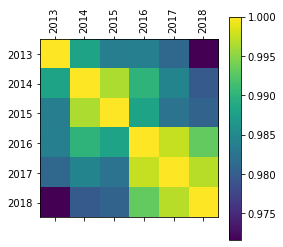

In [11]:
#матрица корреляции GII по годам
f = plt.figure(figsize=(4, 4))
plt.matshow(ds_gii_sum.corr(method ='pearson'), fignum=f.number)
plt.xticks(range(ds_gii_sum.corr(method ='pearson').shape[1]), ds_gii_sum.corr(method ='pearson').columns, fontsize=10, rotation=90)
plt.yticks(range(ds_gii_sum.corr(method ='pearson').shape[1]), ds_gii_sum.corr(method ='pearson').columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
#plt.title('Correlation Matrix GII', fontsize=16)

## Исследую интегральные показатели

In [12]:
integer_fe = dataset['integr_fe']

#подготавливаю датасет интегральных показателей: добавляю регион, удаляю не нужные столбцы
for i in integer_fe.keys():
    #переимменовываю индесы по столбцу 'Indicator'
    integer_fe[i] = integer_fe[i].rename(index = integer_fe[i]['Indicator'])
    
    # удаляю столюцы 'Indicator' и '201*'
    integer_fe[i].drop(['Indicator'], axis = 1, inplace = True)
    integer_fe[i].drop([list(integer_fe[i])[0]], axis = 1, inplace = True)

In [13]:
#добавляю регион
for df_name in integer_fe.keys():
    integer_fe[df_name] = integer_fe[df_name].append(pd.Series(None, name='region'))
    for i in list(dataset['region']['country']):
            try:
                integer_fe[df_name][i].region = list(dataset['region']['region'].loc[dataset['region']['country'] == i])[0]
            except: pass

D:\Program_Files\Anaconda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Program_Files\Anaconda\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
D:\Program_Files\Anaconda\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
# pandas в некоторых датасетах не видит числа. Этот код преобразует object в числа
for ds in integer_fe.keys():
    integer_fe[ds].iloc[:4] = integer_fe[ds].iloc[:4].apply(pd.to_numeric, errors='coerce')

In [15]:
#сумма integral fe по регионам и годам на 1 страну в регионе
sum_int_fe = {}
for ds in integer_fe.keys():
    group_intfe = integer_fe[ds].T.groupby('region').sum().reset_index()
    for fe in range(len(list(group_intfe)[1:])-1):
        ife = integer_fe[ds].iloc[[fe, 5]].T.groupby('region').sum().reset_index().iloc[:,1]
        cfe = integer_fe[ds].T.groupby('region').count().reset_index().iloc[:,1]
        group_intfe.iloc[:,fe + 1] = ife / cfe
    sum_int_fe[ds] = group_intfe    

#### Загружаю датасет с GNI и GII по странам с 2013 по 2019 гг.

In [16]:
gni_wb = dataset['GNI']
gni_wb

Aruba        Angola       Albania  United Arab Emirates  \
2013  2.537095e+09  1.268098e+11  1.299652e+10          3.905705e+11   
2014  2.662514e+09  1.368623e+11  1.335045e+10          4.037961e+11   
2015  2.794804e+09  1.102861e+11  1.152102e+10          3.598777e+11   
2016  2.830726e+09  9.585017e+10  1.205434e+10          3.591417e+11   
2017  2.885754e+09  1.146182e+11  1.305373e+10          3.883829e+11   
2018  2.794804e+09  9.352368e+10  1.512983e+10          4.236391e+11   
2019  2.794804e+09  8.719892e+10  1.512160e+10          4.232008e+11   

         Argentina       Armenia  Antigua and Barbuda     Australia  \
2013  5.388603e+11  1.180401e+10         1.142788e+09  1.536980e+12   
2014  5.147058e+11  1.213173e+10         1.185965e+09  1.429083e+12   
2015  5.826447e+11  1.098175e+10         1.263884e+09  1.324064e+12   
2016  5.453392e+11  1.079129e+10         1.328013e+09  1.180244e+12   
2017  6.263150e+11  1.193483e+10         1.400095e+09  1.293973e+12   
2018  5.012443e+11  1.261910e+10         1.527959e+09  1.389127e+12   
2019  4.323023e+11  1.390079e+10         1.628059e+09  1.346629e+12   

           Austria    Azerbaijan  ...  United States of America    Uzbekistan  \
2013  4.312288e+11  7.003672e+10  ...              1.717590e+13  6.931948e+10   
2014  4.425787e+11  7.266244e+10  ...              1.805749e+13  7.777239e+10   
2015  3.780581e+11  5.104664e+10  ...              1.870432e+13  8.327094e+10   
2016  3.951979e+11  3.539543e+10  ...              1.904516e+13  8.271051e+10   
2017  4.145994e+11  3.910606e+10  ...              1.983028e+13  6.037083e+10   
2018  4.542580e+11  4.465335e+10  ...              2.083735e+13  5.189966e+10   
2019  4.459123e+11  4.598663e+10  ...              2.162500e+13  5.879469e+10   

      Saint Vincent and the Grenadines       Vietnam       Vanuatu  \
2013                      7.174866e+08  1.638848e+11  7.969825e+08   
2014                      6.978554e+08  1.773606e+11  8.198440e+08   
2015                      7.371804e+08  1.833205e+11  7.618370e+08   
2016                      7.691900e+08  1.966866e+11  8.022217e+08   
2017                      7.865489e+08  2.069165e+11  8.691737e+08   
2018                      8.031151e+08  2.280568e+11  9.145894e+08   
2019                      8.187931e+08  2.422738e+11  9.259626e+08   

             Samoa        Kosovo         Yemen        Zambia      Zimbabwe  
2013  7.425405e+08  7.236587e+09  3.859962e+10  2.689667e+10  1.721342e+10  
2014  7.271251e+08  7.548252e+09  4.058679e+10  2.659869e+10  1.764328e+10  
2015  7.722542e+08  6.545821e+09  3.562176e+10  2.083134e+10  1.798077e+10  
2016  7.807764e+08  6.800975e+09  2.808468e+10  2.030766e+10  1.877295e+10  
2017  8.053038e+08  7.393009e+09  2.456133e+10  2.472343e+10  2.007960e+10  
2018  7.904918e+08  8.076835e+09  2.757889e+10  2.659825e+10  2.270665e+10  
2019  8.133550e+08  8.092812e+09  3.185322e+10  2.276668e+10  1.983585e+10  

[7 rows x 180 columns]

In [17]:
gii = dataset['GII'].drop(index = 'region', axis  = 1)
gii = gii.astype('float')
gii

Albania  Algeria  Argentina  Armenia  Australia  Austria  Azerbaijan  \
2013     93.0    138.0       56.0     59.0       19.0     23.0       105.0   
2014     94.0    133.0       70.0     65.0       17.0     20.0       101.0   
2015     87.0    126.0       72.0     61.0       17.0     18.0        93.0   
2016     92.0    113.0       81.0     60.0       19.0     20.0        85.0   
2017     93.0    108.0       76.0     59.0       23.0     20.0        82.0   
2018     83.0    110.0       80.0     68.0       20.0     21.0        82.0   
2019     83.0    113.0       73.0     64.0       22.0     21.0        84.0   

      Bahrain  Bangladesh  Belarus  ...     Guyana     Lesotho       Sudan  \
2013     67.0       130.0     77.0  ...  78.000000  124.000000  141.000000   
2014     62.0       129.0     58.0  ...  80.000000  117.000000  143.000000   
2015     59.0       129.0     53.0  ...  86.000000  118.000000  141.000000   
2016     57.0       117.0     79.0  ...  81.333333  119.666667  141.666667   
2017     66.0       114.0     88.0  ...  81.333333  119.666667  141.666667   
2018     72.0       116.0     86.0  ...  81.333333  119.666667  141.666667   
2019     78.0       116.0     72.0  ...  81.333333  119.666667  141.666667   

      Swaziland  Syrian Arab Republic  Trinidad and Tobago  Uzbekistan  \
2013      104.0                 134.0            81.000000  133.000000   
2014      127.0                 134.0            90.000000  128.000000   
2015      123.0                 134.0            80.000000  122.000000   
2016      118.0                 134.0            83.666667  127.666667   
2017      118.0                 134.0            91.000000  127.666667   
2018      118.0                 134.0            96.000000  127.666667   
2019      118.0                 134.0            91.000000  127.666667   

        Zimbabwe     Myanmar  Seychelles  
2013  132.000000  140.000000   51.000000  
2014  130.000000  140.000000   51.000000  
2015  133.000000  138.000000   65.000000  
2016  131.666667  139.333333   55.666667  
2017  121.000000  139.333333   55.666667  
2018  113.000000  139.333333   55.666667  
2019  122.000000  139.333333   55.666667  

[7 rows x 143 columns]

## Проверяю гипотезы

### u-test the Mann-Whitney для GII и GNI

In [18]:
errlog_giigni_u = list() #пременная для отлова пустых столбщов из-за не несовпадения названий
utest_gii_gni = pd.DataFrame(data = None, columns = list(gni_wb), index = ['statistic','pvalue'])
for col in utest_gii_gni.columns:
    try:
        utest_gii_gni.loc['statistic', col] = mannwhitneyu(gii[col], gni_wb[col]).statistic
        utest_gii_gni.loc['pvalue', col] = mannwhitneyu(gii[col], gni_wb[col]).pvalue
    except: errlog_giigni_u.append(col)

nulls = utest_gii_gni.isnull().sum()
nulls[nulls > 0]  

Aruba                                           2
Antigua and Barbuda                             2
Burundi                                         2
Commonwealth of The Bahamas                     2
Bhutan                                          2
Comoros                                         2
Cuba                                            2
Curaçao                                         2
Cayman Islands                                  2
Djibouti                                        2
Dominica                                        2
Equatorial Guinea                               2
Grenada                                         2
Haiti                                           2
Isle of Man                                     2
Iraq                                            2
Kiribati                                        2
Saint Kitts and Nevis                           2
Liberia                                         2
Libya                                           2


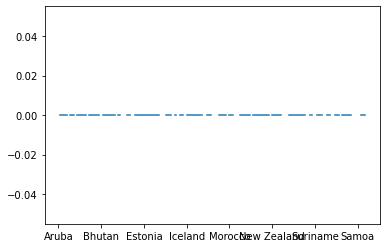

In [19]:
utest_gii_gni.loc['statistic'].plot()

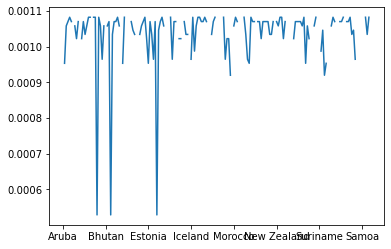

In [20]:
utest_gii_gni.loc['pvalue'].plot()

По всем странам pvalue << меньше порогового значения __0.05__, считаем, что данные коррелируют и есть взаимосвязь, следовательно, можно приступать к анализу показателей.

### u-test the Mann-Whitney для интегральных показателей и GNI

In [21]:
mean_int_fe = pd.DataFrame(data = None, columns = list(gni_wb), index = list(gni_wb.index))

i = 0
for ds in dataset['integr_fe'].keys():
    mean_int_fe.iloc[i] = dataset['integr_fe'][ds].drop('region').mean()
    i += 1
mean_int_fe

Aruba Angola Albania United Arab Emirates Argentina Armenia  \
2013   NaN    132    80.6                 32.6     107.8    62.2   
2014     0  124.6    85.8                 32.4     114.4    64.6   
2015     0  128.4    79.6                 29.4     113.4    57.4   
2016    76      0      79                 28.2     107.2    64.2   
2017   NaN    NaN    71.2                 29.4     107.8      64   
2018   NaN    NaN      70                 32.6      98.8    72.2   
2019   NaN    NaN     NaN                  NaN      97.2     NaN   

     Antigua and Barbuda Australia Austria Azerbaijan  ...  \
2013                 NaN      17.4    16.2         99  ...   
2014                   0      19.4    18.2       95.6  ...   
2015                   0      16.2    20.4       93.6  ...   
2016                  76        17    21.8       81.4  ...   
2017                 NaN      20.2    21.8       76.6  ...   
2018                 NaN      18.4    23.2       73.2  ...   
2019                 NaN      16.2    21.8        NaN  ...   

     United States of America Uzbekistan Saint Vincent and the Grenadines  \
2013                       12      120.8                              NaN   
2014                     15.6        119                                0   
2015                       12      107.4                                0   
2016                       13          0                               76   
2017                       12        NaN                              NaN   
2018                     10.6        NaN                              NaN   
2019                      NaN        NaN                              NaN   

     Vietnam Vanuatu Samoa Kosovo  Yemen Zambia Zimbabwe  
2013    90.8     NaN   NaN    NaN  129.8   93.6    122.4  
2014    94.2       0     0      0  128.2   86.6      114  
2015    90.4       0     0      0  120.6   87.4    123.2  
2016    87.2      76    76     76  122.8   91.2        0  
2017    78.4     NaN   NaN    NaN  118.2   92.2      113  
2018    71.4     NaN   NaN    NaN    122   94.8    115.4  
2019     NaN     NaN   NaN    NaN  101.8    NaN      NaN  

[7 rows x 180 columns]

In [22]:
nulls = mean_int_fe.isnull().sum()
print('Количество стран в датсете с пропусками:', len(nulls), '\n')
print('Страны с пропущенными значениями более 3:')
print(nulls[nulls > 3])

Количество стран в датсете с пропусками: 180 

Страны с пропущенными значениями более 3:
Aruba                                           4
Antigua and Barbuda                             4
Commonwealth of The Bahamas                     4
Bhutan                                          4
Comoros                                         4
Cuba                                            4
Curaçao                                         4
Cayman Islands                                  4
Djibouti                                        4
Dominica                                        4
Equatorial Guinea                               4
Grenada                                         4
Haiti                                           4
Isle of Man                                     4
Iraq                                            4
Kiribati                                        4
Saint Kitts and Nevis                           4
Liberia                                         4
Saint Lucia

In [23]:
#заполняю пропуски
for i in nulls[nulls > 0].keys():
    if i in nulls[nulls > 3]:
        mean_int_fe.drop(i, axis = 1, inplace = True)
    else: 
        mean_int_fe[i] = mean_int_fe[i].fillna(mean_int_fe[i].mean())
mean_int_fe

Angola  Albania  United Arab Emirates Argentina  Armenia Australia  \
2013  132.00     80.6             32.600000     107.8     62.2      17.4   
2014  124.60     85.8             32.400000     114.4     64.6      19.4   
2015  128.40     79.6             29.400000     113.4     57.4      16.2   
2016    0.00     79.0             28.200000     107.2     64.2        17   
2017   96.25     71.2             29.400000     107.8     64.0      20.2   
2018   96.25     70.0             32.600000      98.8     72.2      18.4   
2019   96.25     77.7             30.766667      97.2     64.1      16.2   

     Austria  Azerbaijan  Burundi Belgium  ...   Tanzania     Uganda  Ukraine  \
2013    16.2   99.000000     0.00    21.2  ...  77.800000  80.800000     92.6   
2014    18.2   95.600000   108.60    24.4  ...  82.800000  72.000000       94   
2015    20.4   93.600000   101.00    28.4  ...  79.600000  81.000000     91.6   
2016    21.8   81.400000    93.20    32.8  ...  84.600000  70.800000     86.4   
2017    21.8   76.600000    88.00    33.4  ...  79.600000  73.400000       85   
2018    23.2   73.200000    78.16    30.2  ...  71.600000  72.200000     89.4   
2019    21.8   86.566667    78.16    24.4  ...  79.333333  75.033333     86.6   

        Uruguay  United States of America  Uzbekistan Vietnam  Yemen  \
2013  75.800000                 12.000000       120.8    90.8  129.8   
2014  81.600000                 15.600000       119.0    94.2  128.2   
2015  77.200000                 12.000000       107.4    90.4  120.6   
2016  71.600000                 13.000000         0.0    87.2  122.8   
2017  73.400000                 12.000000        86.8    78.4  118.2   
2018  69.600000                 10.600000        86.8    71.4    122   
2019  74.866667                 12.533333        86.8    85.4  101.8   

         Zambia Zimbabwe  
2013  93.600000    122.4  
2014  86.600000    114.0  
2015  87.400000    123.2  
2016  91.200000      0.0  
2017  92.200000    113.0  
2018  94.800000    115.4  
2019  90.966667     98.0  

[7 rows x 140 columns]

In [24]:
utest_int_fe = pd.DataFrame(data = None, columns = mean_int_fe.columns, index = ['statistic','pvalue'])
errlog_int_fe = list() #пременная для отлова пустых столбщов из-за не несовпадения названий стран
for col in utest_int_fe.columns:
    try:
        utest_int_fe.loc['statistic', col] = mannwhitneyu(mean_int_fe[col], gni_wb[col]).statistic
        utest_int_fe.loc['pvalue', col] = mannwhitneyu(mean_int_fe[col], gni_wb[col]).pvalue
    except: errlog_int_fe.append(col)

utest_int_fe 

Angola     Albania United Arab Emirates   Argentina  \
statistic           0           0                    0           0   
pvalue     0.00103439  0.00108251           0.00105828  0.00107035   

              Armenia   Australia     Austria  Azerbaijan     Burundi  \
statistic           0           0           0           0           0   
pvalue     0.00108251  0.00107035  0.00103439  0.00108251  0.00107035   

              Belgium  ...    Tanzania      Uganda     Ukraine     Uruguay  \
statistic           0  ...           0           0           0           0   
pvalue     0.00107035  ...  0.00107035  0.00108251  0.00108251  0.00108251   

          United States of America  Uzbekistan     Vietnam       Yemen  \
statistic                        0           0           0           0   
pvalue                  0.00103439  0.00103439  0.00108251  0.00108251   

               Zambia    Zimbabwe  
statistic           0           0  
pvalue     0.00108251  0.00108251  

[2 rows x 140 columns]

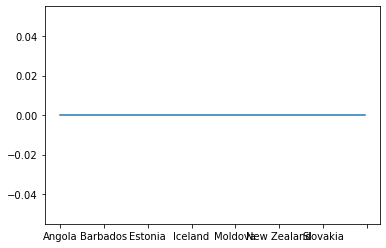

In [25]:
utest_int_fe.loc['statistic'].plot()

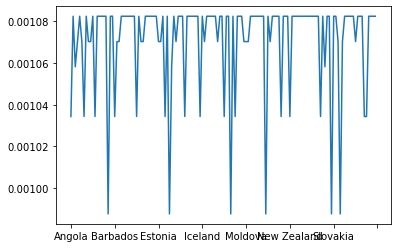

In [26]:
utest_int_fe.loc['pvalue'].plot()

По всем странам pvalue << меньше порогового значения __0.05__, чититаем, что данные коррелируют и есть взаимосвязь, следовательно, можно приступать к анализу показателей.

### u-test the Mann-Whitney для показателей государственной поддержки и GNI

In [27]:
mean_fe = pd.DataFrame(data = None, columns = list(gni_wb), index = list(gni_wb.index))
i = 0
for ds in list(dataset.keys())[:7]:
    mean_fe.iloc[i] = dataset[ds].mean()
    i += 1

In [28]:
nulls = mean_fe.isnull().sum()
print('Количество стран в датсете с пропусками:', len(nulls), '\n')
print('Страны с пропущенными значениями более 3:')
print(nulls[nulls > 3])

Количество стран в датсете с пропусками: 180 

Страны с пропущенными значениями более 3:
Aruba                                           6
Angola                                          4
Antigua and Barbuda                             6
Commonwealth of The Bahamas                     6
Belize                                          6
Barbados                                        4
Bhutan                                          4
Comoros                                         6
Cape Verde                                      4
Cuba                                            6
Curaçao                                         6
Cayman Islands                                  6
Djibouti                                        6
Dominica                                        6
Fiji                                            4
Gabon                                           6
Equatorial Guinea                               6
Grenada                                         6
Guyana     

In [29]:
#заплняю пропуски
for i in nulls[nulls > 0].keys():
    if i in nulls[nulls > 3]:
        mean_fe.drop(i, axis = 1, inplace = True)
    else: 
        mean_fe[i] = mean_fe[i].fillna(mean_fe[i].mean())
mean_fe

Albania  United Arab Emirates Argentina  Armenia Australia  Austria  \
2013  69.8919             32.729730   68.7568  58.2162   24.8108  24.7027   
2014   64.027             32.540541   70.3784  58.0541   24.3784  29.1081   
2015  65.2571             27.800000   74.3714  55.4857   27.4286  25.0857   
2016  64.9444             34.138889   69.5833  56.2778   26.5556     26.5   
2017  63.5556             31.000000   69.9444  60.2222   26.3333       27   
2018  61.3429             29.114286   65.4857  59.7429      24.6  30.0571   
2019       66             31.220574   64.5429     62.6      26.8  29.3714   

     Azerbaijan    Burundi  Belgium      Benin  ...   Turkey Tanzania  \
2013    78.0541  80.863749       24  88.567568  ...  68.0811  71.2432   
2014    70.5676  83.810811  30.5946  86.837838  ...  64.1622  73.1622   
2015    70.6571  82.485714  34.8571  77.276430  ...  63.5714  73.9429   
2016    62.8056  79.111111  32.9167  71.166667  ...  58.7778  77.6389   
2017    58.9444  78.111111     35.5  70.972222  ...  63.1944  78.6667   
2018    57.8286  80.863749  33.1143  70.628571  ...  62.1429  75.4286   
2019    55.8286  80.800000     33.6  75.485714  ...  60.1429  80.9714   

       Uganda  Ukraine  Uruguay United States of America  Vietnam    Yemen  \
2013  76.1081  66.8919  61.1892                  21.2973  64.8108  88.6757   
2014  70.6757  67.5676  63.8108                  26.9459  65.6216   88.973   
2015  72.4286  68.2857  60.6571                  25.2571  64.2286  85.6571   
2016  68.0556  63.3333  59.0556                  24.6667  59.8611  69.8056   
2017  72.0556  61.1944  58.9722                  24.5278  61.5833  81.0833   
2018  65.9143  62.8571  58.0571                  23.6286       59  83.3429   
2019  67.8286  64.7429  60.1143                  29.4857  56.7714  79.0571   

       Zambia   Zimbabwe  
2013  69.5676  78.162162  
2014  62.3243  77.837838  
2015     60.8  82.742857  
2016  62.5556  77.978307  
2017  64.9722  74.555556  
2018  73.1429  76.257143  
2019  75.3429  78.314286  

[7 rows x 126 columns]

In [30]:
utest_fe = pd.DataFrame(data = None, columns = mean_int_fe.columns, index = ['statistic','pvalue'])
errlog_fe = list() #пременная для отлова пустых столбщов из-за не несовпадения названий
for col in utest_fe.columns:
    try:
        utest_fe.loc['statistic', col] = mannwhitneyu(mean_fe[col], gni_wb[col]).statistic
        utest_fe.loc['pvalue', col] = mannwhitneyu(mean_fe[col], gni_wb[col]).pvalue
    except: errlog_int_fe.append(col)
utest_fe 

Angola     Albania United Arab Emirates   Argentina     Armenia  \
statistic    NaN           0                    0           0           0   
pvalue       NaN  0.00108251           0.00108251  0.00108251  0.00108251   

            Australia     Austria  Azerbaijan     Burundi     Belgium  ...  \
statistic           0           0           0           0           0  ...   
pvalue     0.00108251  0.00108251  0.00108251  0.00107035  0.00108251  ...   

             Tanzania      Uganda     Ukraine     Uruguay  \
statistic           0           0           0           0   
pvalue     0.00108251  0.00108251  0.00108251  0.00108251   

          United States of America Uzbekistan     Vietnam       Yemen  \
statistic                        0        NaN           0           0   
pvalue                  0.00108251        NaN  0.00108251  0.00108251   

               Zambia    Zimbabwe  
statistic           0           0  
pvalue     0.00108251  0.00108251  

[2 rows x 140 columns]

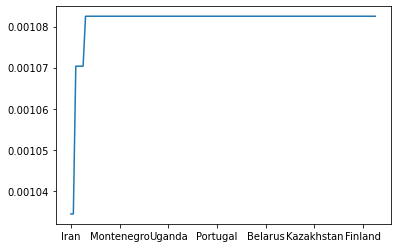

In [31]:
#без выбросов: 1, 2, 3 и 4 МАХ значения
utest_fe.T.sort_values('pvalue',ascending=True)['pvalue'][:-4].plot()

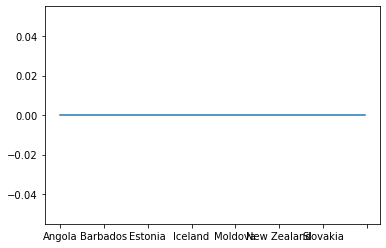

In [32]:
utest_int_fe.loc['statistic'].plot()

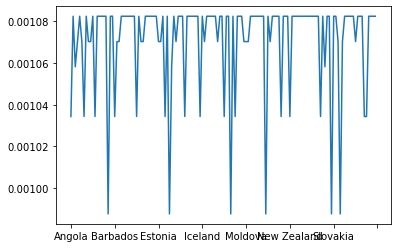

In [33]:
utest_int_fe.loc['pvalue'].plot()

#### Заключение 
Как видно из последнего графика, для, покрайней мере 140 стран, показатели Global Innovation Index (GII) и Gross Natural Income (GNI) имеют сильную корреляцию.
При очищении показателя GII до показателей иллюстирирующих государственную поддержку, зависимость от GNI не тольоко остаётся, но даже её характер не изменяется. 
Из исследования следует, что меры государственной поддержки инновационной системы напрямую влияют на её ВВП и справедливы для всех стран.

## Кластеризация стран

ООН выделяет три группы стран по уровню социально-экономического развития:

• развитые страны (developed countries)  
• страны с переходной экономикой (transition countries)  
• развивающиеся страны (developing countries)

Гипотезы:  
1) Каждую страну в каждом году можно отнести к какой либо группе (классу) по GNI;  
2) Каждую страну в каждом году можно отнести к какой либо группе (классу) по GII;  
3) Каждую страну в каждом году можно отнести к какой либо группе (классу) по GNi + GII;  
4) Каждую страну в каждом году можно отнести к какой либо группе (классу) по 5 интегральным показателям;  
5) Каждую страну в каждом году можно отнести к какой либо группе (классу) по 37 показателям;  
6) Существуют показатели (из набора 37) для каждой страны которые необходимо стимулировать для перехода в следующий класс.

#### Подготовка датасета GNI и GII для кластеризации

In [34]:
gni_kl = gni_wb.astype('float')
gii_kl = gii.iloc[:7].astype('float')
gii_kl

Albania  Algeria  Argentina  Armenia  Australia  Austria  Azerbaijan  \
2013     93.0    138.0       56.0     59.0       19.0     23.0       105.0   
2014     94.0    133.0       70.0     65.0       17.0     20.0       101.0   
2015     87.0    126.0       72.0     61.0       17.0     18.0        93.0   
2016     92.0    113.0       81.0     60.0       19.0     20.0        85.0   
2017     93.0    108.0       76.0     59.0       23.0     20.0        82.0   
2018     83.0    110.0       80.0     68.0       20.0     21.0        82.0   
2019     83.0    113.0       73.0     64.0       22.0     21.0        84.0   

      Bahrain  Bangladesh  Belarus  ...     Guyana     Lesotho       Sudan  \
2013     67.0       130.0     77.0  ...  78.000000  124.000000  141.000000   
2014     62.0       129.0     58.0  ...  80.000000  117.000000  143.000000   
2015     59.0       129.0     53.0  ...  86.000000  118.000000  141.000000   
2016     57.0       117.0     79.0  ...  81.333333  119.666667  141.666667   
2017     66.0       114.0     88.0  ...  81.333333  119.666667  141.666667   
2018     72.0       116.0     86.0  ...  81.333333  119.666667  141.666667   
2019     78.0       116.0     72.0  ...  81.333333  119.666667  141.666667   

      Swaziland  Syrian Arab Republic  Trinidad and Tobago  Uzbekistan  \
2013      104.0                 134.0            81.000000  133.000000   
2014      127.0                 134.0            90.000000  128.000000   
2015      123.0                 134.0            80.000000  122.000000   
2016      118.0                 134.0            83.666667  127.666667   
2017      118.0                 134.0            91.000000  127.666667   
2018      118.0                 134.0            96.000000  127.666667   
2019      118.0                 134.0            91.000000  127.666667   

        Zimbabwe     Myanmar  Seychelles  
2013  132.000000  140.000000   51.000000  
2014  130.000000  140.000000   51.000000  
2015  133.000000  138.000000   65.000000  
2016  131.666667  139.333333   55.666667  
2017  121.000000  139.333333   55.666667  
2018  113.000000  139.333333   55.666667  
2019  122.000000  139.333333   55.666667  

[7 rows x 143 columns]

##### Scaling GNI и GII

In [35]:
scaler_gni = StandardScaler()
scaler_gii = StandardScaler()

gni_sc = scaler_gni.fit_transform(gni_kl)
gii_sc = scaler_gii.fit_transform(gii_kl)

In [36]:
# 3 кластера
kmeans_gni = KMeans(n_clusters = 3, random_state = 42, n_jobs = -1)
kmeans_gii = KMeans(n_clusters = 3, random_state = 42, n_jobs = -1)

In [37]:
for i in range(gni_sc.shape[0]):
    gni_kmeans = kmeans_gni.fit(gni_sc[i].reshape(-1, 1))
    print('Year:', gni_kl.index[i])
    print('GNI labels count:')
    x = gni_kmeans.labels_
    y = np.bincount(x)
    ii = np.nonzero(y)[0]
    print(np.vstack((ii,y[ii])).T, '\n')

Year: 2013
GNI labels count:
[[ 0 55]
 [ 1 73]
 [ 2 52]] 

Year: 2014
GNI labels count:
[[ 0 64]
 [ 1 51]
 [ 2 65]] 

Year: 2015
GNI labels count:
[[ 0 71]
 [ 1 29]
 [ 2 80]] 

Year: 2016
GNI labels count:
[[  0  66]
 [  1 101]
 [  2  13]] 

Year: 2017
GNI labels count:
[[ 0 60]
 [ 1 44]
 [ 2 76]] 

Year: 2018
GNI labels count:
[[  0 112]
 [  1  26]
 [  2  42]] 

Year: 2019
GNI labels count:
[[  0 114]
 [  1  56]
 [  2  10]] 



Классы распределены равномерно.
Необходимо проверить, как влияет на количество кластеров scale и нормирование. Для модели предпочтительно иметь как можно большее количество класов, поскольку это повысит количество границ перехода страны из класса в класс и может показать более точно показатели, которые влияют на этот переход.

#### Поиск оптимального количества кластеров для scaled GNI

No handles with labels found to put in legend.


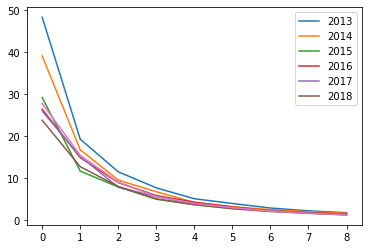

In [38]:
fig, ax = plt.subplots()

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in range(gni_sc.shape[0]):
    ssd = []
    for num_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters = num_clusters, random_state = 42, max_iter = 300, n_jobs = -1)
        kmeans.fit(gni_sc[i].reshape(-1, 1))
        ssd.append(kmeans.inertia_)
    ax.legend()
    plt.plot(ssd, label = gni_kl.index[i])

In [39]:
range_n_clusters = [2, 3, 4, 5, 6, 7]

for i in range(gni_sc.shape[0]):
    print('GNI. Year:', gni_kl.index[i])
    for num_clusters in range_n_clusters:
        # intialise kmeans
        kmeans = KMeans(n_clusters = num_clusters, random_state = 42, max_iter = 300)
        kmeans.fit(gni_sc[i].reshape(-1, 1))
    
        cluster_labels = kmeans.labels_
    
        # silhouette score
        silhouette_avg = silhouette_score(gni_sc[i].reshape(-1, 1), cluster_labels)
        print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    print('\n')

GNI. Year: 2013
For n_clusters=2, the silhouette score is 0.6479128410580406
For n_clusters=3, the silhouette score is 0.6358490526722875
For n_clusters=4, the silhouette score is 0.6134355460276819
For n_clusters=5, the silhouette score is 0.5639268398018982
For n_clusters=6, the silhouette score is 0.5681550008823859
For n_clusters=7, the silhouette score is 0.5626042265270255


GNI. Year: 2014
For n_clusters=2, the silhouette score is 0.6323886745069051
For n_clusters=3, the silhouette score is 0.6198878647064296
For n_clusters=4, the silhouette score is 0.618960532308714
For n_clusters=5, the silhouette score is 0.613161619920778
For n_clusters=6, the silhouette score is 0.627664018097231
For n_clusters=7, the silhouette score is 0.6133555599310568


GNI. Year: 2015
For n_clusters=2, the silhouette score is 0.5889573107010535
For n_clusters=3, the silhouette score is 0.6182747730292726
For n_clusters=4, the silhouette score is 0.6066603557740174
For n_clusters=5, the silhouette sco

Максимальное значение silhouette score зависит от года и колеблется от 2 до 7. Однозначно сложно определить количество классов. Целесообразно провести проверку, альтернативным методом, например MeanShift().

In [40]:
#Проверяю исходный GNI с помощью MeanShift() на количество классов
count = int()
for i in range(gni_sc.shape[0]):
    print('GNI. Year:', gni_kl.index[i])
    ms = MeanShift()
    ms.fit(gni_sc[i].reshape(-1, 1))
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters_ = len(np.unique(labels))
    count += n_clusters_
    
    print("Estimated clusters:", n_clusters_, '\n')
print('Среднеарифметическое количество кластеров:', round(count/i))

GNI. Year: 2013
Estimated clusters: 3 

GNI. Year: 2014
Estimated clusters: 3 

GNI. Year: 2015
Estimated clusters: 3 

GNI. Year: 2016
Estimated clusters: 4 

GNI. Year: 2017
Estimated clusters: 2 

GNI. Year: 2018
Estimated clusters: 2 

GNI. Year: 2019
Estimated clusters: 4 

Среднеарифметическое количество кластеров: 4


Организация объединённых наций разделяет страны по GNI на 3 класса, однако, как видно, класс страны сильно колеблется от года, по этому целесообразно разделять страны на 4 класса.

#### Поиск оптимального количества классов для scaled GII

In [41]:
for i in range(gii_sc.shape[0]):
    gii_kmeans = kmeans_gii.fit(gii_sc[i].reshape(-1, 1))
    print('Year:', gii_kl.index[i])
    print('GII labels count:')
    x = gii_kmeans.labels_
    y = np.bincount(x)
    ii = np.nonzero(y)[0]
    print(np.vstack((ii,y[ii])).T, '\n')
print('Среднеарифметическое количество кластеров:', round(count/i))

Year: 2013
GII labels count:
[[ 0 42]
 [ 1 61]
 [ 2 40]] 

Year: 2014
GII labels count:
[[ 0 60]
 [ 1 56]
 [ 2 27]] 

Year: 2015
GII labels count:
[[ 0 46]
 [ 1 57]
 [ 2 40]] 

Year: 2016
GII labels count:
[[ 0 45]
 [ 1 63]
 [ 2 35]] 

Year: 2017
GII labels count:
[[ 0 68]
 [ 1 55]
 [ 2 20]] 

Year: 2018
GII labels count:
[[ 0 48]
 [ 1 30]
 [ 2 65]] 

Year: 2019
GII labels count:
[[ 0 35]
 [ 1 58]
 [ 2 50]] 

Среднеарифметическое количество кластеров: 4


No handles with labels found to put in legend.


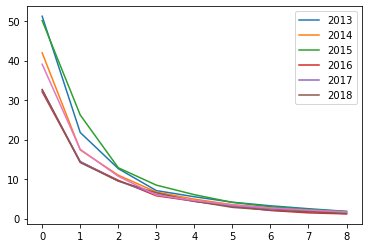

In [42]:
# Поиск оптимального количества классов для GII
fig, ax = plt.subplots()

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in range(gii_sc.shape[0]):
    ssd = []
    for num_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters = num_clusters, random_state = 42, max_iter = 300, n_jobs = -1)
        kmeans.fit(gii_sc[i].reshape(-1, 1))
        ssd.append(kmeans.inertia_)
    ax.legend()
    plt.plot(ssd, label = gii_kl.index[i])

In [43]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 9, 10]

for i in range(gii_sc.shape[0]):
    print('GII. Year:', gii_kl.index[i])
    for num_clusters in range_n_clusters:
        # intialise kmeans
        kmeans = KMeans(n_clusters = num_clusters, random_state = 42, max_iter = 300)
        kmeans.fit(gii_sc[i].reshape(-1, 1))
    
        cluster_labels = kmeans.labels_
    
        # silhouette score
        silhouette_avg = silhouette_score(gii_sc[i].reshape(-1, 1), cluster_labels)
        print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    print('\n')

GII. Year: 2013
For n_clusters=2, the silhouette score is 0.6730766271282643
For n_clusters=3, the silhouette score is 0.6348262745125693
For n_clusters=4, the silhouette score is 0.6053188283999466
For n_clusters=5, the silhouette score is 0.6103608242896574
For n_clusters=6, the silhouette score is 0.5845732489616748
For n_clusters=7, the silhouette score is 0.5640180634214219
For n_clusters=9, the silhouette score is 0.5731289708741372
For n_clusters=10, the silhouette score is 0.5836638818070455


GII. Year: 2014
For n_clusters=2, the silhouette score is 0.6034599631827656
For n_clusters=3, the silhouette score is 0.6266818516097991
For n_clusters=4, the silhouette score is 0.5780193856712839
For n_clusters=5, the silhouette score is 0.5813941996478295
For n_clusters=6, the silhouette score is 0.581286571835454
For n_clusters=7, the silhouette score is 0.5811039610065137
For n_clusters=9, the silhouette score is 0.5920081531938771
For n_clusters=10, the silhouette score is 0.616124

Максимальное значение silhouette score зависит от года и колеблется от 2 до 9. Однозначно сложно определить количество классов. Для нахождения количества классов воспользуюсь тем же методом -  MeanShift().

In [44]:
#Проверяю scaled GII с помощью MeanShift() на количество классов
count = int()
for i in range(gii_sc.shape[0]):
    print('GII. Year:', gii_kl.index[i])
    ms = MeanShift()
    ms.fit(gii_sc[i].reshape(-1, 1))
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters_ = len(np.unique(labels))
    count += n_clusters_
    print("Estimated clusters:", n_clusters_, '\n')
print('Среднеарифметическое количество кластеров:', round(count/i))

GII. Year: 2013
Estimated clusters: 4 

GII. Year: 2014
Estimated clusters: 3 

GII. Year: 2015
Estimated clusters: 3 

GII. Year: 2016
Estimated clusters: 3 

GII. Year: 2017
Estimated clusters: 2 

GII. Year: 2018
Estimated clusters: 4 

GII. Year: 2019
Estimated clusters: 2 

Среднеарифметическое количество кластеров: 4


In [45]:
#Проверяю scaled GII с помощью MeanShift() на количество классов
gii_nrm = normalize(gii_sc)

count = int()
for i in range(gii_sc.shape[0]):
    print('GII. Year:', gii_kl.index[i])
    ms = MeanShift()
    ms.fit(gii_nrm[i].reshape(-1, 1))
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters_ = len(np.unique(labels))
    count += n_clusters_
    print("Estimated clusters:", n_clusters_, '\n')
print('Среднеарифметическое количество кластеров:', round(count/i))

GII. Year: 2013
Estimated clusters: 4 

GII. Year: 2014
Estimated clusters: 3 

GII. Year: 2015
Estimated clusters: 3 

GII. Year: 2016
Estimated clusters: 3 

GII. Year: 2017
Estimated clusters: 2 

GII. Year: 2018
Estimated clusters: 4 

GII. Year: 2019
Estimated clusters: 2 

Среднеарифметическое количество кластеров: 4


### Выводы

Проверка MeanShift() показала, что количество кластеров для GII, как и GNI так же меняется год от года. Cреднеарифметическое количество кластеров равно для GNI - 3, а для GII - 3. В дальнейших расчётах буду использовать количество кластеров равное **3**, для всех наборов показателей.

In [46]:
#Рассчёт кластеров GII
# формирование словаря KMeans n_clusters = 3

# рассчёт KMeans для GII 
gii_kmeans_labels = {}
gii_kmeans_fe = {}
kmeans3_gii = {}

n_clusters = 4

kmeans3_gii = KMeans(n_clusters = n_clusters, random_state = 42, n_jobs = -1)

#нормализованные данные
kmeans3_gii_nrm = {}
gii_kmeans_labels_nrm = {}
gii_kmeans_fe_nrm = {}
kmeans3_gii_nrm = KMeans(n_clusters = n_clusters, random_state = 42, n_jobs = -1)


for i in range(len(gii_kl.index)):
    eyear_ind = gii_kl.index[i]
    # scale датасет
    kmeans3_gii = KMeans(n_clusters = n_clusters, random_state = 42, n_jobs = -1)
    gii_kmeans_labels[eyear_ind] = kmeans3_gii.fit(gii_sc[i].T.reshape(-1, 1))
    gii_kmeans_fe[eyear_ind] =  kmeans3_gii.fit_transform(gii_sc[i].reshape(-1, 1))
    
    #нормализованные данные
    kmeans3_gii_nrm = KMeans(n_clusters = n_clusters, random_state = 42, n_jobs = -1)
    gii_kmeans_labels_nrm[eyear_ind] = kmeans3_gii_nrm.fit(gii_nrm[i].reshape(-1, 1))
    gii_kmeans_fe_nrm[eyear_ind] =  kmeans3_gii_nrm.fit_transform(gii_nrm[i].reshape(-1, 1)) 

In [47]:
#scaled gii
gii_labels = pd.DataFrame()
for year in gii_kmeans_labels.keys():
    temp_s = pd.Series(data = gii_kmeans_labels[year].labels_, index = gii.loc[year].index, name = year)
    gii_labels = gii_labels.append(temp_s).astype('int')
gii_labels += 1 #добавляю 1, что бы кластеры нумеровались с 1, а не с 0

#нормализованный gii
gii_labels_nrm = pd.DataFrame()
for year in gii_kmeans_labels_nrm.keys():
    temp_s = pd.Series(data = gii_kmeans_labels_nrm[year].labels_, index = gii.loc[year].index, name = year)
    gii_labels_nrm = gii_labels_nrm.append(temp_s).astype('int')
gii_labels_nrm += 1 #добавляю 1, что бы кластеры нумеровались с 1, а не с 0

Графики кластеров нескольких стран

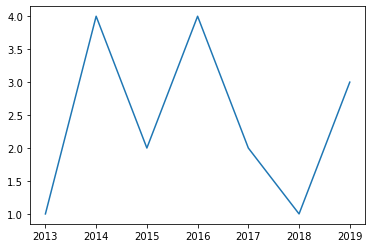

In [48]:
gii_labels["Germany"].plot()

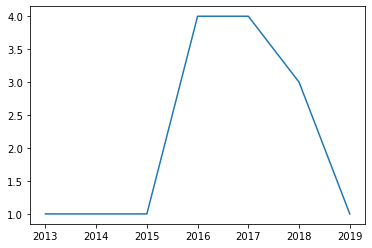

In [49]:
gii_labels["Russian Federation"].plot()

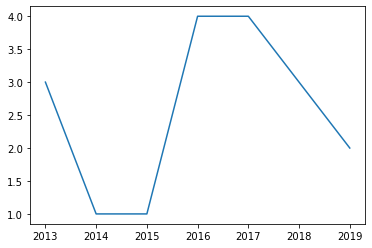

In [50]:
gii_labels["United States of America"].plot()

## Двухфакторная кластеризация

Однофакторная классификация может не полностью отражать положение страны, то есть её кластер, поскольку индекс GII слишком узкий показатель, основанный на части субъективных оценок.  
Для уточнения кластера провожу двухфакторную кластеризацию по GII и GNI.

In [51]:
# подготовка списка столбцов
col_list_gii_gni = list(set(gii.columns.append(gni_wb.columns)))
col_list_gii_gni.sort()

#Создание словаря с датафремами GII и GNI по годам
gii_gni_dict = {}
gii_gni = pd.DataFrame(data = None, columns = col_list_gii_gni, index = ['GII', 'GNI'])

#Создаю словарь с датасетами {год: страны [GII, GNI]} 
for ind in gii_kl.index:
    gii_gni_temp = pd.DataFrame(data = None, columns = col_list_gii_gni, index = ['GII', 'GNI'])
    gii_gni_temp.loc['GII'] = gii_kl.loc[ind]
    gii_gni_temp.loc['GNI'] = gni_kl.loc[str(ind)]
    gii_gni_temp.dropna(axis = 1, how = 'any', inplace = True)
    gii_gni_dict[ind] = gii_gni_temp

In [52]:
#Поскольку размерности GNI и GII отличаются на сотни порядков логарифмирую GNI для 'сближения' данных
for ds in gii_gni_dict.keys():
    for i in range(len(gii_gni_dict[ds].columns)):
        gii_gni_dict[ds].iloc[1,i] = np.log10(gii_gni_dict[ds].iloc[1,i])

In [53]:
#определяю количество кластеров с помощью MeanShift()
for ds in gii_gni_dict.keys():
    ms = MeanShift()
    ms.fit(gii_gni_dict[ds].T)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters_ = len(np.unique(labels))
    count += n_clusters_
    print(ds)
    print(ms.labels_)
    print("Estimated clusters:", n_clusters_, '\n')

2013
[2 2 2 1 1 1 1 2 0 2 1 0 1 2 2 2 0 0 0 1 2 2 2 1 2 1 1 1 1 1 1 1 1 0 0 0 1
 2 2 1 1 2 0 1 2 1 0 0 2 1 1 0 0 2 1 1 1 2 0 1 1 0 2 1 2 1 0 2 1 1 2 2 1 2
 1 1 0 1 0 1 2 2 2 2 0 2 1 1 2 2 2 1 0 2 0 2 0 0 1 1 1 2 1 1 1 1 2 1 2 1 1
 1 1 1 1 2 2 1 1 2 2 1 2 0 0 0 0 0 1 1 1 1 2 0 2 2 2]
Estimated clusters: 3 

2014
[1 3 3 0 0 2 2 1 0 3 2 0 2 1 3 3 1 1 0 0 3 3 3 2 1 0 2 0 0 0 2 2 2 1 3 1 2
 3 1 2 2 3 1 2 1 0 1 1 3 2 2 1 1 3 2 2 2 3 1 2 0 1 1 0 3 2 1 3 2 2 3 3 2 3
 2 2 0 0 0 0 1 3 3 3 1 3 2 2 3 3 3 2 1 3 0 1 1 1 0 2 0 3 2 0 0 0 1 2 1 0 0
 2 2 2 2 3 3 2 2 3 3 0 3 1 1 0 1 0 2 2 2 1 3 0 3 3 3]
Estimated clusters: 4 

2015
[0 0 0 1 1 2 2 0 1 0 2 1 2 0 0 0 0 0 1 1 0 0 0 2 0 1 2 1 1 1 2 2 2 0 0 0 2
 0 0 2 2 0 0 2 0 1 0 0 0 2 2 0 0 0 2 2 2 0 0 2 0 0 0 0 0 2 0 0 1 2 0 0 2 0
 2 1 1 1 1 1 0 0 0 0 0 0 2 2 0 0 0 2 1 0 1 0 1 0 1 2 1 0 2 1 1 1 0 1 0 1 1
 2 2 2 2 0 0 2 2 0 0 1 0 0 0 1 0 1 1 2 2 1 0 1 0 0 0]
Estimated clusters: 3 

2016
[0 0 0 0 1 2 2 0 1 0 2 0 2 0 0 0 0 0 1 2 0 0 0 2 0 2 2 1 2 1 2 2 2 1 0 

In [54]:
#подбор оптимального количества класторов
#Гипотеза: количество кластеров не может быть постоянным, постколько количество кластеров GII и GNI
#меняется год от года, не зависио друг от друга.

# Проверка инструментом DBSCAN
count = int() #счётчик максимальных значений кластеров
sum_y = int() #количество учётнных кластеров >0

for year in gii_gni_dict.keys():
    print(year) 
    for i in range(len(gii_gni_dict.keys())+3):
        clustering = DBSCAN(eps=2, min_samples = i, n_jobs = -1).fit(gii_gni_dict[year].T)
        print('Количество кластеров:', clustering.labels_.max())
        if clustering.labels_.max() >=1:
            count += clustering.labels_.max()
            sum_y+=1
    print('\n')
print('Среднее количество кластеров:', count/sum_y)

2013
Количество кластеров: 18
Количество кластеров: 18
Количество кластеров: 13
Количество кластеров: 12
Количество кластеров: 1
Количество кластеров: -1
Количество кластеров: -1
Количество кластеров: -1
Количество кластеров: -1
Количество кластеров: -1


2014
Количество кластеров: 19
Количество кластеров: 19
Количество кластеров: 14
Количество кластеров: 13
Количество кластеров: 2
Количество кластеров: -1
Количество кластеров: -1
Количество кластеров: -1
Количество кластеров: -1
Количество кластеров: -1


2015
Количество кластеров: 22
Количество кластеров: 22
Количество кластеров: 17
Количество кластеров: 13
Количество кластеров: 3
Количество кластеров: -1
Количество кластеров: -1
Количество кластеров: -1
Количество кластеров: -1
Количество кластеров: -1


2016
Количество кластеров: 17
Количество кластеров: 17
Количество кластеров: 13
Количество кластеров: 11
Количество кластеров: 4
Количество кластеров: 1
Количество кластеров: 1
Количество кластеров: 0
Количество кластеров: -1
Количе

Принимаю количество кластеров равное 10.

In [55]:
kmeans3_gii_gni10 = {}
gii_gni_kmeans_fe10 = {}
gii_gni_kmeans_labels10 = {}

for ds in gii_gni_dict.keys():
    kmeans3_gii_gni10[ds] = KMeans(n_clusters = 10, random_state = 42, n_jobs = -1)
    
    gii_gni_kmeans_labels10[ds] = kmeans3_gii_gni10[ds].fit(gii_gni_dict[ds].T)
    gii_gni_kmeans_fe10[ds] =  kmeans3_gii_gni10[ds].fit_transform(gii_gni_dict[ds].T)

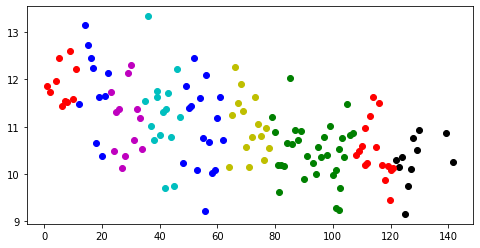

In [56]:
#визуализация 3 классоов для gii_gni_dict[2013]
fig, ax = plt.subplots()
colors = 1000*['r','g','b','c','k','y','m']

ds = 2019

labels = gii_gni_kmeans_labels10[ds].labels_
a = 0
b = 1
for i in range(len(gii_gni_kmeans_fe10[ds])):
    ax.scatter(gii_gni_dict[ds].iloc[a,i], 
               gii_gni_dict[ds].iloc[b,i], c = colors[labels[i]])
fig.set_figheight(4)
fig.set_figwidth(8)
plt.show()

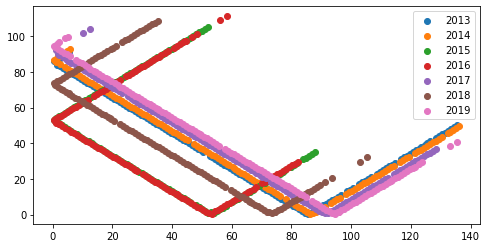

In [57]:
a = 0 # range (0,1)
b = 1 # range (0,1)

fig, ax = plt.subplots()

for i in gii_gni_kmeans_fe10.keys():
    ax.scatter(gii_gni_kmeans_fe10[i].T[a], gii_gni_kmeans_fe10[i].T[b], label = i)
    ax.legend()

fig.set_figheight(4)
fig.set_figwidth(8)
plt.show()

In [58]:
# датасет кластеры gii_gni_kmeans_labels10 по странам и годам
gii_gni_labels10 = pd.DataFrame()

for year in gii_gni_kmeans_labels10.keys():
    temp_s = pd.Series(data = gii_gni_kmeans_labels10[year].labels_,
                       index = gii_gni_dict[year].columns,
                       name = year)
    gii_gni_labels10 = gii_gni_labels10.append(temp_s).astype('int')
gii_gni_labels10 += 1 #добавляю 1, что бы кластеры нумеровались с 1, а не с 0
gii_gni_labels10

Albania  Algeria  Angola  Argentina  Armenia  Australia  Austria  \
2013        2        7       7          3       10          9        9   
2014        2        4       4          5        5          7        7   
2015        5        4      10          7        7          6        6   
2016        5        3       7          1        6          8        8   
2017        3        6       1          9        5          4        4   
2018        3        2       8          3        5          4        4   
2019        9        8       5          6        6         10       10   

      Azerbaijan  Bahrain  Bangladesh  ...  Ukraine  United Arab Emirates  \
2013           8       10           7  ...       10                     5   
2014           2        5          10  ...        5                     3   
2015           8        1           4  ...        7                     1   
2016           1        6           3  ...        6                    10   
2017           9        5          10  ...        8                     2   
2018           3        5           6  ...        1                     1   
2019           9        6           8  ...        4                     4   

      United Kingdom  United States of America  Uruguay  Uzbekistan  Vietnam  \
2013               1                         1        3           7        6   
2014               1                         1        5          10        5   
2015               3                         3        7          10        1   
2016               4                         4        9           7        6   
2017               7                         7        5           1        8   
2018               9                         9        5           6        7   
2019               1                         4        3           5        4   

      Yemen  Zambia  Zimbabwe  
2013      7       4         7  
2014      4      10         4  
2015      4      10         4  
2016      7       7         7  
2017      1       1        10  
2018      6       6         2  
2019      5       5         5  

[7 rows x 137 columns]

Text(0, 0.5, 'Claster')

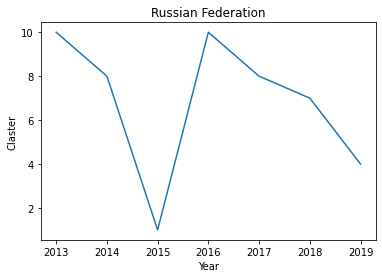

In [59]:
country = "Russian Federation"
gii_gni_labels10[country].plot()
plt.title(country)
plt.xlabel('Year')
plt.ylabel('Claster')

Text(0, 0.5, 'Claster')

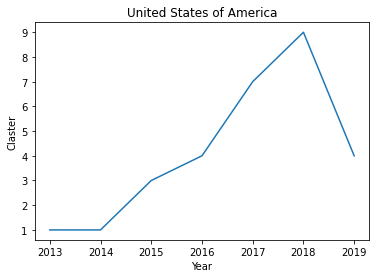

In [60]:
country = "United States of America"
gii_gni_labels10[country].plot()
plt.title(country)
plt.xlabel('Year')
plt.ylabel('Claster')

Text(0, 0.5, 'Claster')

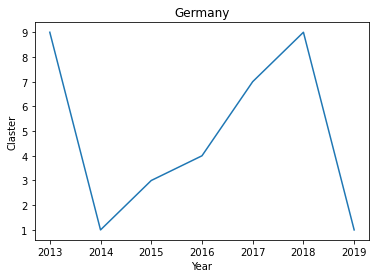

In [61]:
country = "Germany"
gii_gni_labels10[country].plot()
plt.title(country)
plt.xlabel('Year')
plt.ylabel('Claster')

## Интегральные показатели   
* Political environment  
* Regulatory environment  
* Credit	  
* Innovation linkages

In [62]:
# привожу к одной шкале датасет 'integr_fe'
intfe_dict_sc = {}
scaler_inffe = StandardScaler()

#scaled датасет 'integr_fe'
for ds in dataset['integr_fe'].keys():
    intfe_dict_sc[ds] = scaler_inffe.fit_transform(dataset['integr_fe'][ds].drop('region', axis = 0).astype('float').T)
    
# нормализация датасет 'integr_fe'
intfe_dict_nrm = {}
for ds in intfe_dict_sc.keys():    
    intfe_dict_nrm[ds] = normalize(intfe_dict_sc[ds])
    #intfe_dict_nrm[ds] =  normalize(dataset['integr_fe'][ds].drop('region', axis = 0).astype('float').T)

In [63]:
# применяю MeanShift к scaled датасет 'integr_fe'
count = int()
n_clusters_ = int()
for ds in dataset['integr_fe'].keys():
    ms = MeanShift()
    ms.fit(intfe_dict_sc[ds].T)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters_ = len(np.unique(labels))
    count += n_clusters_
    print(ds)
    print(cluster_centers.shape)    
    print("Estimated clusters:", n_clusters_, '\n')
print('Среднее количества кластров:', count/len(dataset['integr_fe'].keys()))
print('Среднее количество кластров:', round(count/len(dataset['integr_fe'].keys())))

int_fe_2013
(4, 148)
Estimated clusters: 4 

int_fe_2014
(3, 224)
Estimated clusters: 3 

int_fe_2015
(5, 224)
Estimated clusters: 5 

int_fe_2016
(4, 224)
Estimated clusters: 4 

int_fe_2017
(1, 126)
Estimated clusters: 1 

int_fe_2018
(2, 125)
Estimated clusters: 2 

int_fe_2019
(3, 127)
Estimated clusters: 3 

Среднее количества кластров: 3.142857142857143
Среднее количество кластров: 3


In [64]:
#применяю плавающее количество кластеров, подобно GII
kmeans_fe_fl = {
    'int_fe_2013' : KMeans(n_clusters = 3, random_state = 42, n_jobs = -1),
    'int_fe_2014' : KMeans(n_clusters = 3, random_state = 42, n_jobs = -1),
    'int_fe_2015' : KMeans(n_clusters = 4, random_state = 42, n_jobs = -1),
    'int_fe_2016' : KMeans(n_clusters = 3, random_state = 42, n_jobs = -1),
    'int_fe_2017' : KMeans(n_clusters = 2, random_state = 42, n_jobs = -1),
    'int_fe_2018' : KMeans(n_clusters = 4, random_state = 42, n_jobs = -1),
    'int_fe_2019' : KMeans(n_clusters = 2, random_state = 42, n_jobs = -1) }

intfe_dict_kmeans_fl_labels = {}
intfe_dict_kmeans_fl_fe = {}
count = int()

for ds in intfe_dict_nrm.keys():
    intfe_dict_kmeans_fl_labels[ds] = kmeans_fe_fl[ds].fit(intfe_dict_nrm[ds])
    intfe_dict_kmeans_fl_fe[ds] = kmeans_fe_fl[ds].fit_transform(intfe_dict_nrm[ds])
    count += len(np.unique(intfe_dict_kmeans_fl_labels[ds].labels_)) 
    
    #печать 
    print(ds)
    print('Количество кластеров:', len(np.unique(intfe_dict_kmeans_fl_labels[ds].labels_)))
    print(intfe_dict_kmeans_fl_fe[ds].shape, '\n')
print('Среднее количества кластров:', count/len(intfe_dict_nrm.keys()))
print('Среднее количество кластров:', round(count/len(intfe_dict_nrm.keys())))

int_fe_2013
Количество кластеров: 3
(148, 3) 

int_fe_2014
Количество кластеров: 3
(224, 3) 

int_fe_2015
Количество кластеров: 4
(224, 4) 

int_fe_2016
Количество кластеров: 3
(224, 3) 

int_fe_2017
Количество кластеров: 2
(126, 2) 

int_fe_2018
Количество кластеров: 4
(125, 4) 

int_fe_2019
Количество кластеров: 2
(127, 2) 

Среднее количества кластров: 3.0
Среднее количество кластров: 3


Количество кластеров во всех рассчетах 3.  
Приведени к единому количеству кластеров, видимо не совсем корректно, однако, датасет содержит аппроксимации данных и нулевые значачения, кроме того, предполага, что приемственность кластеров сохраняется при переходе на низший уровень структуры GII.

In [65]:
# 3 класса и нормализованные данные
# рассчёт классов и координат KMeans()
kmeans_fe = {}
n_cls = 3

for key in intfe_dict_nrm.keys():
    kmeans_fe[key] = KMeans(n_clusters = n_cls, random_state = 42, n_jobs = -1)
    
intfe_dict_kmeans_nrm_labels = {}
intfe_dict_kmeans_nrm_fe = {}

for ds_sc in intfe_dict_sc.keys():
    intfe_dict_kmeans_nrm_labels[ds_sc] = kmeans_fe[ds_sc].fit(intfe_dict_nrm[ds_sc])
    intfe_dict_kmeans_nrm_fe[ds_sc] = kmeans_fe[ds_sc].fit_transform(intfe_dict_nrm[ds_sc])

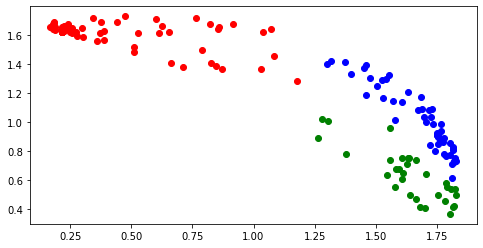

In [66]:
#визуализация 3 классоов для int_fe_2013
fig, ax = plt.subplots()
colors = 1000*['r','g','b','c','k','y','m']

labels = intfe_dict_kmeans_nrm_labels['int_fe_2013'].labels_

a = 0
b = 1
for i in range(len(intfe_dict_kmeans_nrm_fe['int_fe_2013'].T[a])):
    ax.scatter(intfe_dict_kmeans_nrm_fe['int_fe_2013'].T[a][i], 
               intfe_dict_kmeans_nrm_fe['int_fe_2013'].T[b][i], c = colors[labels[i]])
fig.set_figheight(4)
fig.set_figwidth(8)
plt.show()

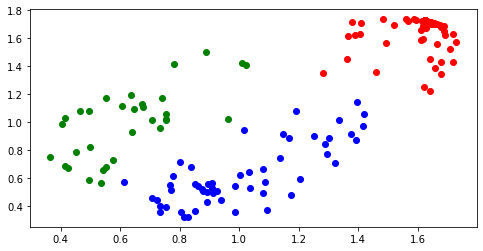

In [67]:
fig, ax = plt.subplots()
colors = 1000*['r','g','b','c','k','y','m']

labels = intfe_dict_kmeans_nrm_labels['int_fe_2013'].labels_

a = 1
b = 2
for i in range(len(intfe_dict_kmeans_nrm_fe['int_fe_2013'].T[a])):
    ax.scatter(intfe_dict_kmeans_nrm_fe['int_fe_2013'].T[a][i], 
               intfe_dict_kmeans_nrm_fe['int_fe_2013'].T[b][i], c = colors[labels[i]])
fig.set_figheight(4)
fig.set_figwidth(8)
plt.show()

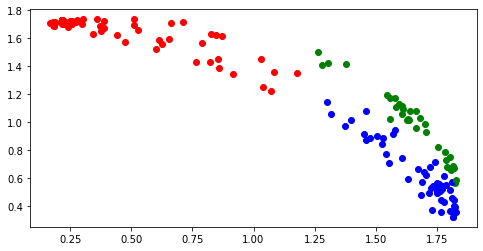

In [68]:
fig, ax = plt.subplots()
colors = 1000*['r','g','b','c','k','y','m']

labels = intfe_dict_kmeans_nrm_labels['int_fe_2013'].labels_

a = 0
b = 2
for i in range(len(intfe_dict_kmeans_nrm_fe['int_fe_2013'].T[a])):
    ax.scatter(intfe_dict_kmeans_nrm_fe['int_fe_2013'].T[a][i], 
               intfe_dict_kmeans_nrm_fe['int_fe_2013'].T[b][i], c = colors[labels[i]])
fig.set_figheight(4)
fig.set_figwidth(8)
plt.show()

Визуализация нормализованного датасета интегральных показателей

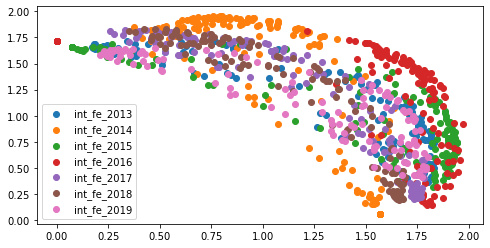

In [69]:
a = 0 # range (0,2)
b = 1 # range (0,2)

fig, ax = plt.subplots()

for i in intfe_dict_kmeans_nrm_fe.keys():
    ax.scatter(intfe_dict_kmeans_nrm_fe[i].T[a], intfe_dict_kmeans_nrm_fe[i].T[b], label = i)
    ax.legend()

fig.set_figheight(4)
fig.set_figwidth(8)
plt.show()

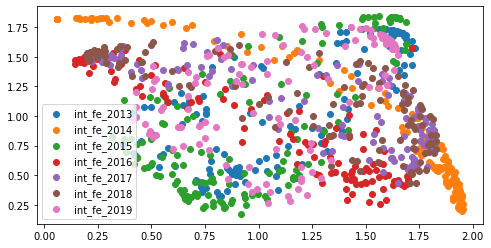

In [70]:
c = 1 # range (0,2)
d = 2 # range (0,2)

fig, ax = plt.subplots()
for i in intfe_dict_kmeans_nrm_fe.keys():
    ax.scatter(intfe_dict_kmeans_nrm_fe[i].T[c], intfe_dict_kmeans_nrm_fe[i].T[d], label = i)
    ax.legend()

fig.set_figheight(4)
fig.set_figwidth(8)    
plt.show()

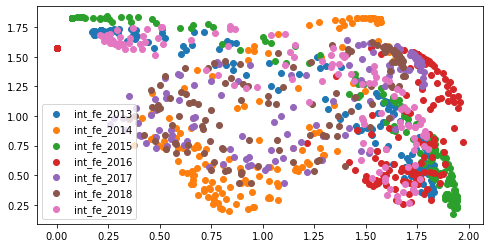

In [71]:
e = 0 # range (0,2)
f = 2 # range (0,2)

fig, ax = plt.subplots()
for i in intfe_dict_kmeans_nrm_fe.keys():
    ax.scatter(intfe_dict_kmeans_nrm_fe[i].T[e], intfe_dict_kmeans_nrm_fe[i].T[f], label = i)
    ax.legend()

fig.set_figheight(4)
fig.set_figwidth(8)    
plt.show()

Очевидно, сто страны меняют своё положение в классах от года к году  

Сокращаю размерность для визуализации хотя бы в 3D

In [72]:
intfe_dict_kmeans3_labels = intfe_dict_kmeans_nrm_labels
intfe_dict_kmeans3_fe = intfe_dict_kmeans_nrm_fe

#### Графики в 3Д

In [73]:
x = intfe_dict_kmeans3_fe['int_fe_2013'].T[0]
y = intfe_dict_kmeans3_fe['int_fe_2013'].T[1]
z = intfe_dict_kmeans3_fe['int_fe_2013'].T[2]
fig = px.scatter_3d(x=x, y=y, z=z, color = intfe_dict_kmeans3_labels['int_fe_2013'].labels_)
fig.show()

In [74]:
x = intfe_dict_kmeans3_fe['int_fe_2014'].T[0]
y = intfe_dict_kmeans3_fe['int_fe_2014'].T[1]
z = intfe_dict_kmeans3_fe['int_fe_2014'].T[2]
fig = px.scatter_3d(x=x, y=y, z=z, color = intfe_dict_kmeans3_labels['int_fe_2014'].labels_)
fig.show()

In [75]:
x = intfe_dict_kmeans3_fe['int_fe_2015'].T[0]
y = intfe_dict_kmeans3_fe['int_fe_2015'].T[1]
z = intfe_dict_kmeans3_fe['int_fe_2015'].T[2]
fig = px.scatter_3d(x=x, y=y, z=z, color = intfe_dict_kmeans3_labels['int_fe_2015'].labels_)
fig.show()

In [76]:
x = intfe_dict_kmeans3_fe['int_fe_2016'].T[0]
y = intfe_dict_kmeans3_fe['int_fe_2016'].T[1]
z = intfe_dict_kmeans3_fe['int_fe_2016'].T[2]
fig = px.scatter_3d(x=x, y=y, z=z, color = intfe_dict_kmeans3_labels['int_fe_2016'].labels_)
fig.show()

In [77]:
x = intfe_dict_kmeans3_fe['int_fe_2017'].T[0]
y = intfe_dict_kmeans3_fe['int_fe_2017'].T[1]
z = intfe_dict_kmeans3_fe['int_fe_2017'].T[2]
fig = px.scatter_3d(x=x, y=y, z=z, color = intfe_dict_kmeans3_labels['int_fe_2017'].labels_)
fig.show()

In [78]:
x = intfe_dict_kmeans3_fe['int_fe_2018'].T[0]
y = intfe_dict_kmeans3_fe['int_fe_2018'].T[1]
z = intfe_dict_kmeans3_fe['int_fe_2018'].T[2]
fig = px.scatter_3d(x=x, y=y, z=z, color = intfe_dict_kmeans3_labels['int_fe_2018'].labels_)
fig.show()

In [79]:
x = intfe_dict_kmeans3_fe['int_fe_2019'].T[0]
y = intfe_dict_kmeans3_fe['int_fe_2019'].T[1]
z = intfe_dict_kmeans3_fe['int_fe_2019'].T[2]
fig = px.scatter_3d(x=x, y=y, z=z, color = intfe_dict_kmeans3_labels['int_fe_2019'].labels_)
fig.show()

---

### Набор из 37 показателей, характеризующих государственную поддержку инновационной системы

Поиск количества кластеров для pack_37

In [80]:
pack37 = {}
for ds in list(dataset.keys())[:7]:
    pack37[ds] = dataset[ds]

In [81]:
# привожу шкалы датасето 37 показателей к одной
pack37_sc = {}
scaler_pack37 = StandardScaler()

for ds in list(dataset.keys())[:7]:
    pack37_sc[ds] = scaler_pack37.fit_transform(dataset[ds].drop([dataset[ds].columns[0], 
                                                               dataset[ds].columns[1]], axis = 1).astype('float').T)
# нормализаци данных
pack37_nrm = {}
for ds in list(dataset.keys())[:7]:
    pack37_nrm[ds] =  normalize(pack37_sc[ds])
    #pack37_nrm[ds] = dataset[ds].drop([dataset[ds].columns[0], dataset[ds].columns[1]], axis = 1).astype('float').T

In [82]:
# 3 класса - беру по аналогии с GII и GNI
# формирование словаря KMeans
kmeans_pack37 = {}
kmeans_pack37_nrm = {}
n_clusters = 3

for key in pack37_sc.keys():
    kmeans_pack37[key] = KMeans(n_clusters = n_clusters, random_state = 42, n_jobs = -1)
    
    #нормализованныt данные
    kmeans_pack37_nrm[key] = KMeans(n_clusters = n_clusters, random_state = 42, n_jobs = -1)
     
# рассчёт KMeans для scaled pack37
pack37_kmeans_labels = {}
pack37_kmeans_fe = {}

#нормализованные данные
pack37_kmeans_labels_nrm = {}
pack37_kmeans_fe_nrm = {}

for ds in pack37_sc.keys():
    # scale датасет
    pack37_kmeans_labels[ds] = kmeans_pack37[ds].fit(pack37_sc[ds])
    pack37_kmeans_fe[ds] =  kmeans_pack37[ds].fit_transform(pack37_sc[ds])
    
    #нормализованные данные
    pack37_kmeans_labels_nrm[ds] = kmeans_pack37_nrm[ds].fit(pack37_nrm[ds])
    pack37_kmeans_fe_nrm[ds] =  kmeans_pack37_nrm[ds].fit_transform(pack37_nrm[ds])        

# применяю MeanShift к нормализованному датасету
count = int()
for ds in pack37_kmeans_fe_nrm.keys():
    ms = MeanShift()
    ms.fit(pack37_kmeans_fe_nrm[ds].T)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters_ = len(np.unique(labels))
    count += n_clusters_
    print(ds)
    print(cluster_centers.shape)    
    print("Estimated clusters:", n_clusters_, '\n')
print('Среднее количества кластров:', count/len(pack37_kmeans_fe_nrm.keys()))
print('Среднее количество кластров:', round(count/len(pack37_kmeans_fe_nrm.keys())))

In [83]:
#применяю плавающее количество кластеров
kmeans_37_fe_fl = {
    '2013' : KMeans(n_clusters = 3, random_state = 42, n_jobs = -1),
    '2014' : KMeans(n_clusters = 3, random_state = 42, n_jobs = -1),
    '2015' : KMeans(n_clusters = 3, random_state = 42, n_jobs = -1),
    '2016' : KMeans(n_clusters = 3, random_state = 42, n_jobs = -1),
    '2017' : KMeans(n_clusters = 2, random_state = 42, n_jobs = -1),
    '2018' : KMeans(n_clusters = 4, random_state = 42, n_jobs = -1),
    '2019' : KMeans(n_clusters = 2, random_state = 42, n_jobs = -1) }

# плавающее количество классов
pack37_dict_kmeans_fl_labels = {}
pack37_dict_kmeans_fl_fe = {}
count = int()

for ds in pack37_sc.keys():
    pack37_dict_kmeans_fl_labels[ds] = kmeans_37_fe_fl[ds].fit(pack37_kmeans_fe_nrm[ds])
    pack37_dict_kmeans_fl_fe[ds] = kmeans_37_fe_fl[ds].fit_transform(pack37_kmeans_fe_nrm[ds])
    count += len(np.unique(pack37_dict_kmeans_fl_labels[ds].labels_)) 
    #результаты
    print(ds)
    print('Количество кластеров:', len(np.unique(pack37_dict_kmeans_fl_labels[ds].labels_)))
    print(pack37_dict_kmeans_fl_fe[ds].shape, '\n')
print('Среднее количества кластров:', count/len(pack37_dict_kmeans_fl_labels.keys()))
print('Среднее количество кластров:', round(count/len(pack37_dict_kmeans_fl_labels.keys())))

2013
Количество кластеров: 3
(141, 3) 

2014
Количество кластеров: 3
(142, 3) 

2015
Количество кластеров: 3
(140, 3) 

2016
Количество кластеров: 3
(204, 3) 

2017
Количество кластеров: 2
(126, 2) 

2018
Количество кластеров: 4
(125, 4) 

2019
Количество кластеров: 2
(127, 2) 

Среднее количества кластров: 2.857142857142857
Среднее количество кластров: 3


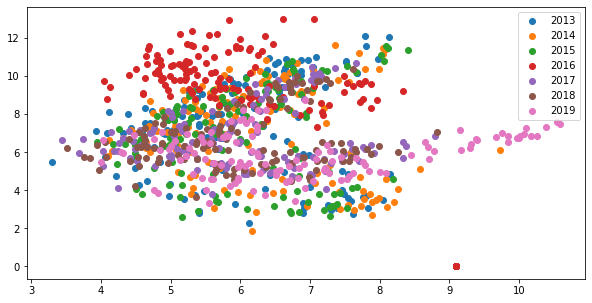

In [84]:
a = 0 # range (0,2)
b = 1 # range (0,2)

fig, ax = plt.subplots()

for i in pack37_kmeans_fe.keys():
    ax.scatter(pack37_kmeans_fe[i].T[a], pack37_kmeans_fe[i].T[b], label = i)
    ax.legend()

fig.set_figheight(5)
fig.set_figwidth(10) 
plt.show()

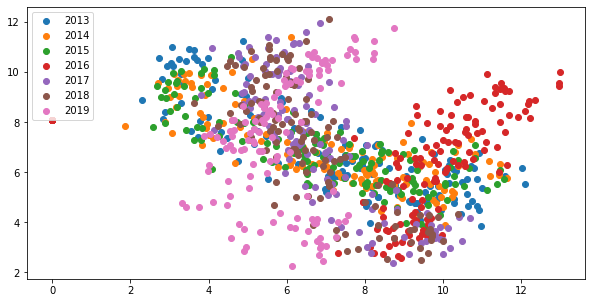

In [85]:
c = 1 # range (0,2)
d = 2 # range (0,2)

fig, ax = plt.subplots()
for i in pack37_kmeans_fe.keys():
    ax.scatter(pack37_kmeans_fe[i].T[c], pack37_kmeans_fe[i].T[d], label = i)
    ax.legend()

fig.set_figheight(5)
fig.set_figwidth(10) 
plt.show()

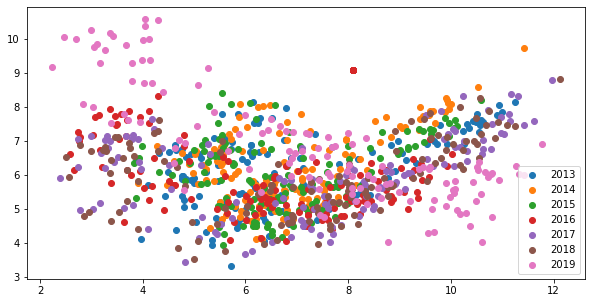

In [86]:
c = 2 # range (0,2)
d = 0 # range (0,2)

fig, ax = plt.subplots()
for i in pack37_kmeans_fe.keys():
    ax.scatter(pack37_kmeans_fe[i].T[c], pack37_kmeans_fe[i].T[d], label = i)
    ax.legend()

fig.set_figheight(5)
fig.set_figwidth(10) 
plt.show()

In [87]:
for i in pack37_kmeans_fe.keys():
    x = pack37_kmeans_fe[i].T[0]
    y = pack37_kmeans_fe[i].T[1]
    z = pack37_kmeans_fe[i].T[2]
    fig = px.scatter_3d(x=x, y=y, z=z, color = pack37_kmeans_labels[i].labels_, title = i)
    fig.show()

In [88]:
# формирование словаря KMeans
kmeans3_pack37 = {}
kmeans3_pack37_nrm = {}
n_clusters = 3

for key in pack37_nrm.keys():
    kmeans3_pack37[key] = KMeans(n_clusters = n_clusters, random_state = 42, n_jobs = -1)
    
    #нормализованный данные
    kmeans3_pack37_nrm[key] = KMeans(n_clusters = n_clusters, random_state = 42, n_jobs = -1)

In [89]:
# рассчёт KMeans для датасета
pack37_kmeans3_labels = {}
pack37_kmeans3_fe = {}

#нормализованные данные
pack37_kmeans3_labels_nrm = {}
pack37_kmeans3_fe_nrm = {}

for ds in pack37_nrm.keys():
    pack37_kmeans3_labels[ds] = kmeans3_pack37[ds].fit(pack37_sc[ds])
    pack37_kmeans3_fe[ds] =  kmeans3_pack37[ds].fit_transform(pack37_sc[ds])
    
    #нормализованные данные
    pack37_kmeans3_labels_nrm[ds] = kmeans3_pack37_nrm[ds].fit(pack37_nrm[ds])
    pack37_kmeans3_fe_nrm[ds] =  kmeans3_pack37_nrm[ds].fit_transform(pack37_nrm[ds])  

In [90]:
#визуализация распределения по классам scaled pack37
for i in pack37_kmeans3_fe.keys():
    x = pack37_kmeans3_fe[i].T[0]
    y = pack37_kmeans3_fe[i].T[1]
    z = pack37_kmeans3_fe[i].T[2]
    fig = px.scatter_3d(x=x, y=y, z=z, color = pack37_kmeans3_labels[i].labels_, title = i)
    fig.show()

In [91]:
#визуализация распределения по классам нормированных данных
for i in pack37_kmeans3_fe_nrm.keys():
    x = pack37_kmeans3_fe_nrm[i].T[0]
    y = pack37_kmeans3_fe_nrm[i].T[1]
    z = pack37_kmeans3_fe_nrm[i].T[2]
    fig = px.scatter_3d(x=x, y=y, z=z, color = pack37_kmeans3_labels_nrm[i].labels_, title = i)
    fig.show()

Нормализованный дататсет

In [92]:
#Нормализованный датасет с классами стран
pack37_labels_nrm = pd.DataFrame()
lebels_2013 = pd.Series(data = pack37_kmeans3_labels_nrm['2013'].labels_,index = pack37['2013'].columns[2:], name = '2013')
lebels_2014 = pd.Series(data = pack37_kmeans3_labels_nrm['2014'].labels_,index = pack37['2014'].columns[2:], name = '2014')
lebels_2015 = pd.Series(data = pack37_kmeans3_labels_nrm['2015'].labels_,index = pack37['2015'].columns[2:], name = '2015')
lebels_2016 = pd.Series(data = pack37_kmeans3_labels_nrm['2016'].labels_,index = pack37['2016'].columns[2:], name = '2016')
lebels_2017 = pd.Series(data = pack37_kmeans3_labels_nrm['2017'].labels_,index = pack37['2017'].columns[2:], name = '2017')
lebels_2018 = pd.Series(data = pack37_kmeans3_labels_nrm['2018'].labels_,index = pack37['2018'].columns[2:], name = '2018')
lebels_2019 = pd.Series(data = pack37_kmeans3_labels_nrm['2019'].labels_,index = pack37['2019'].columns[2:], name = '2019')
pack37_labels_nrm = pack37_labels_nrm.append([lebels_2013,lebels_2014,lebels_2015,lebels_2016, lebels_2017,lebels_2018, lebels_2019])
pack37_labels_nrm += 1
pack37_labels_nrm.fillna(0, inplace = True)
pack37_labels_nrm

Albania  Algeria  Angola  Argentina  Armenia  Australia  Austria  \
2013      3.0      3.0     3.0        1.0      1.0        2.0      2.0   
2014      1.0      1.0     3.0        1.0      1.0        2.0      2.0   
2015      1.0      2.0     2.0        1.0      1.0        3.0      3.0   
2016      2.0      2.0     0.0        2.0      2.0        3.0      3.0   
2017      1.0      2.0     0.0        1.0      1.0        3.0      3.0   
2018      1.0      3.0     0.0        1.0      1.0        2.0      2.0   
2019      1.0      3.0     0.0        1.0      1.0        2.0      2.0   

      Azerbaijan  Bahrain  Bangladesh  ...  Taiwan  \
2013         3.0      1.0         3.0  ...     0.0   
2014         1.0      2.0         3.0  ...     0.0   
2015         1.0      1.0         2.0  ...     0.0   
2016         2.0      3.0         2.0  ...     1.0   
2017         1.0      1.0         2.0  ...     0.0   
2018         1.0      1.0         3.0  ...     0.0   
2019         1.0      1.0         3.0  ...     0.0   

      Democratic Republic of Timor-Leste  Tokelau  Tonga  Turkmenistan  \
2013                                 0.0      0.0    0.0           0.0   
2014                                 0.0      0.0    0.0           0.0   
2015                                 0.0      0.0    0.0           0.0   
2016                                 1.0      1.0    1.0           1.0   
2017                                 0.0      0.0    0.0           0.0   
2018                                 0.0      0.0    0.0           0.0   
2019                                 0.0      0.0    0.0           0.0   

      Turks and Caicos Islands  Tuvalu  Vanuatu  Virgin Islands, British  \
2013                       0.0     0.0      0.0                      0.0   
2014                       0.0     0.0      0.0                      0.0   
2015                       0.0     0.0      0.0                      0.0   
2016                       1.0     1.0      1.0                      1.0   
2017                       0.0     0.0      0.0                      0.0   
2018                       0.0     0.0      0.0                      0.0   
2019                       0.0     0.0      0.0                      0.0   

      Virgin Islands, U.S.  
2013                   0.0  
2014                   0.0  
2015                   0.0  
2016                   1.0  
2017                   0.0  
2018                   0.0  
2019                   0.0  

[7 rows x 222 columns]

Text(0, 0.5, 'Claster')

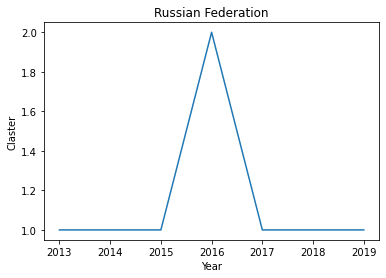

In [93]:
country = "Russian Federation"
pack37_labels_nrm[country].plot()
plt.title(country)
plt.xlabel('Year')
plt.ylabel('Claster')

Text(0, 0.5, 'Claster')

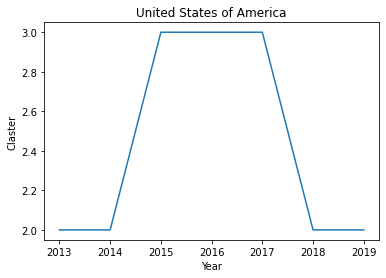

In [94]:
country = "United States of America"
pack37_labels_nrm[country].plot()
plt.title(country)
plt.xlabel('Year')
plt.ylabel('Claster')

Исходный датасет

In [95]:
#датасет с классами стран
pack37_labels = pd.DataFrame()
lebels_2013 = pd.Series(data = pack37_kmeans_labels['2013'].labels_, index = pack37['2013'].columns[2:], name = '2013')
lebels_2014 = pd.Series(data = pack37_kmeans_labels['2014'].labels_,index = pack37['2014'].columns[2:], name = '2014')
lebels_2015 = pd.Series(data = pack37_kmeans_labels['2015'].labels_,index = pack37['2015'].columns[2:], name = '2015')
lebels_2016 = pd.Series(data = pack37_kmeans_labels['2016'].labels_,index = pack37['2016'].columns[2:], name = '2016')
lebels_2017 = pd.Series(data = pack37_kmeans_labels['2017'].labels_,index = pack37['2017'].columns[2:], name = '2017')
lebels_2018 = pd.Series(data = pack37_kmeans_labels['2018'].labels_,index = pack37['2018'].columns[2:], name = '2018')
lebels_2019 = pd.Series(data = pack37_kmeans_labels['2019'].labels_,index = pack37['2019'].columns[2:], name = '2019')
pack37_labels = pack37_labels.append([lebels_2013,lebels_2014,lebels_2015,lebels_2016, lebels_2017,lebels_2018, lebels_2019])
pack37_labels += 1
#pack37_labels.fillna(0, inplace = True)
pack37_labels

Albania  Algeria  Angola  Argentina  Armenia  Australia  Austria  \
2013      1.0      3.0     3.0        1.0      1.0        2.0      2.0   
2014      1.0      1.0     3.0        1.0      1.0        2.0      2.0   
2015      1.0      3.0     3.0        1.0      1.0        2.0      2.0   
2016      1.0      1.0     NaN        1.0      1.0        3.0      3.0   
2017      1.0      2.0     NaN        1.0      1.0        3.0      3.0   
2018      1.0      2.0     NaN        1.0      1.0        3.0      3.0   
2019      2.0      1.0     NaN        2.0      2.0        3.0      3.0   

      Azerbaijan  Bahrain  Bangladesh  ...  Taiwan  \
2013         3.0      2.0         3.0  ...     NaN   
2014         1.0      2.0         3.0  ...     NaN   
2015         1.0      1.0         3.0  ...     NaN   
2016         1.0      3.0         1.0  ...     2.0   
2017         1.0      1.0         2.0  ...     NaN   
2018         1.0      1.0         2.0  ...     NaN   
2019         2.0      2.0         1.0  ...     NaN   

      Democratic Republic of Timor-Leste  Tokelau  Tonga  Turkmenistan  \
2013                                 NaN      NaN    NaN           NaN   
2014                                 NaN      NaN    NaN           NaN   
2015                                 NaN      NaN    NaN           NaN   
2016                                 2.0      2.0    2.0           2.0   
2017                                 NaN      NaN    NaN           NaN   
2018                                 NaN      NaN    NaN           NaN   
2019                                 NaN      NaN    NaN           NaN   

      Turks and Caicos Islands  Tuvalu  Vanuatu  Virgin Islands, British  \
2013                       NaN     NaN      NaN                      NaN   
2014                       NaN     NaN      NaN                      NaN   
2015                       NaN     NaN      NaN                      NaN   
2016                       2.0     2.0      2.0                      2.0   
2017                       NaN     NaN      NaN                      NaN   
2018                       NaN     NaN      NaN                      NaN   
2019                       NaN     NaN      NaN                      NaN   

      Virgin Islands, U.S.  
2013                   NaN  
2014                   NaN  
2015                   NaN  
2016                   2.0  
2017                   NaN  
2018                   NaN  
2019                   NaN  

[7 rows x 222 columns]

In [96]:
#датасет с классами стран
pack37_labels = pd.DataFrame()
lebels_2013 = pd.Series(data = pack37_kmeans_labels['2013'].labels_, index = pack37['2013'].columns[2:], name = '2013')
lebels_2014 = pd.Series(data = pack37_kmeans_labels['2014'].labels_,index = pack37['2014'].columns[2:], name = '2014')
lebels_2015 = pd.Series(data = pack37_kmeans_labels['2015'].labels_,index = pack37['2015'].columns[2:], name = '2015')
lebels_2016 = pd.Series(data = pack37_kmeans_labels['2016'].labels_,index = pack37['2016'].columns[2:], name = '2016')
lebels_2017 = pd.Series(data = pack37_kmeans_labels['2017'].labels_,index = pack37['2017'].columns[2:], name = '2017')
lebels_2018 = pd.Series(data = pack37_kmeans_labels['2018'].labels_,index = pack37['2018'].columns[2:], name = '2018')
lebels_2019 = pd.Series(data = pack37_kmeans_labels['2019'].labels_,index = pack37['2019'].columns[2:], name = '2019')
pack37_labels = pack37_labels.append([lebels_2013,lebels_2014,lebels_2015,lebels_2016, lebels_2017,lebels_2018, lebels_2019])
pack37_labels.fillna(0, inplace = True)
pack37_labels += 1

Text(0, 0.5, 'Claster')

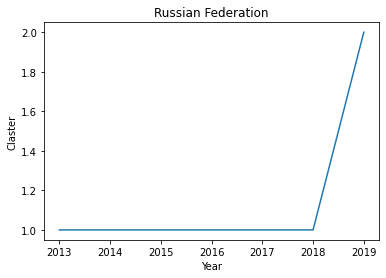

In [97]:
country = "Russian Federation"
pack37_labels[country].plot()
plt.title(country)
plt.xlabel('Year')
plt.ylabel('Claster')

Text(0, 0.5, 'Claster')

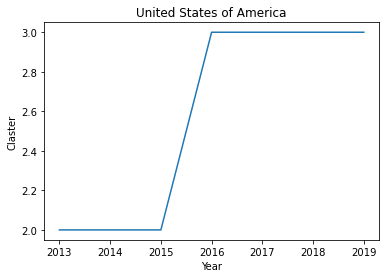

In [98]:
country = "United States of America"
pack37_labels[country].plot()
plt.title(country)
plt.xlabel('Year')
plt.ylabel('Claster')

In [99]:
#Составляю словарь с нумерации страны
col_list = list()
col_dict = {}

for ds in pack37.keys():
    for col in pack37[ds].columns[2:]:
        col_list.append(col)
col_list = list(unique_everseen(col_list))

i = 0
for col in col_list:
    col_dict[col] = i
    i += 1

country_ind = pd.DataFrame(data = None, columns = list(col_dict.keys()), index = pack37.keys())
country_dict = {}
err_list = []

for ds in pack37.keys():
    for col in country_ind.loc[ds].index:
        if col in pack37[ds].columns:
            country_ind.loc[ds][col] = col_dict[col]
        else: 
            err_list.append(col)
            country_ind[col].loc[ds] = np.nan

Гипотеза 1: Изменнее показателей pack 37 оказывает влияние на кластер страны. Если гипотеза верна, то существуют такие показатели из pack 37, которые оказывают наибольшее влияние на изменение кластера страны.

In [100]:
def prep_dfs(dict_df,df_lab, year1, year2, class1, class2):
    
    if check_class(df_lab, class1, class2) == False:
        print('Проверьте классы')
        return str('error')
    
    else: 
        c_y1_y2 = []
        country1  = list(df_lab.loc[year1][df_lab.loc[year1] == class1].index)
        country2  = list(df_lab.loc[year2][df_lab.loc[year2] == class2].index)
        #создаю список стран которые есть в year1 и year2 df_lab
        c_y1_y2 = set(country1).intersection(country2)
        
        year1 = str(year1)
        year2 = str(year2)
        #создаю список стран которые есть в year1 и year2 pack37
        p1 = list(pack37[year1])[2:]
        p2 = list(pack37[year2])[2:]
        p4 = set(p1).intersection(p2)
        p5 = set(p4).intersection(c_y1_y2)
        
        temp_pack37 = dict_df[year1][p5] - dict_df[year2][p5]
        temp_pack37.dropna(axis = 0, inplace = True)
        return temp_pack37

In [101]:
#функция проверяет нахождение введённых классов в диапазоне классов стран
def check_class(df, cl1, cl2):
     #pack37_labels
        
    max_cl = df.max().sort_values(ascending = False)[0]
    min_cl = df.min().sort_values(ascending = False)[-1]
    if cl1 < cl2:
        print('Кластеры указаны не верно: кластер year 2 должен быть больше кластера  year 1')
        return False
    if cl1 > max_cl:
        print(cl1, 'больше максимального значения кластера.')
        return False
    elif  cl2 < min_cl:
        print(cl2, 'меньше минимального значения кластера.')
        return False
    return True

In [102]:
# функция возврящает индексы показатеоей по правилу Паретто: возвращает индексы датафрейма и наименование страны
# на вход подаётся датафрейм сразницей показателей
def significant_parameters(df):
    dict_param = {}
    #print(bool(df))
    #if df == 'error':
        #print('<< Ошибка >>')
        #dict_param[0] = None
       # return dict_param
        
    #dict_param = {}
    for df_columns in df:
        f = []
        temp_df = df[df_columns].loc[df[df_columns] < 0].sort_values(ascending=True)
        summa = temp_df.iloc[0]
        f.append(df[df_columns].loc[df[df_columns] < 0].sort_values(ascending=True).index[0])          
        for ind in range(1, len(df.index)):
            if summa / temp_df.sum() <= .8:
                summa += temp_df.iloc[ind]
                f.append(list(temp_df.index)[ind])
            else:
                break
        dict_param[df_columns] = f
    return dict_param

In [103]:
#Модель работает по алгоритму:
# из датасета pack37[year1] и pack37[year2] берёт датасет страны class1 и class2 соотвественно котрые есть в обоих годах
# затем вычитает эти два датасета
# после вычета берёт индексы показателей сумма показателей которых >= 80% от суммы показателей страны для каждой страны
# и возвращает эти показатели

sign_par = {}
year1 = 2016 #year1 должен быть > year2 и находится в диапахоне от 2013 до 2019
year2 = 2015
class1 = 2 #кластер в year1 
class2 = 1 #кластер в year2

#Объекты содержащие кластеры:
#gii_labels - однофакторная кластеризация
#pack37_labels,
#gii_gni_labels10 - двухфакторная кластеризация

temp_pack37 = prep_dfs(pack37, gii_labels, year1, year2, class1, class2) #однофакторная кластеризация
#temp_pack37 = prep_dfs(pack37, gii_gni_labels10, year1, year2, class1, class2) #двухфакторная кластеризация

sign_par = significant_parameters(temp_pack37)

year1 = str(year1)
year2 = str(year2)
if len(sign_par) != 0 :
    for key in sign_par:
        print(key)
        print(pack37[year1]['Indicator'].loc[sign_par[key]], '\n')
else:
       print('Стран с такими параметрами не найдено')

Switzerland
70    University/industry research collaboration
27          Graduates in science and engineering
71                  State of cluster development
11                            Regulatory quality
9                       Government effectiveness
Name: Indicator, dtype: object 

Paraguay
8     Political stability and absence of violence/te...
12                                          Rule of law
20                             Expenditure on education
16                         Ease of resolving insolvency
11                                   Regulatory quality
17                                 Ease of paying taxes
Name: Indicator, dtype: object 

Spain
74        Patent families filed in at least two offices
8     Political stability and absence of violence/te...
17                                 Ease of paying taxes
Name: Indicator, dtype: object 

Saudi Arabia
72                              GERD financed by abroad
50                               Ease of getting credit


In [104]:
#частотность параметров в выборке
list_param = []
indicator = str
for key in sign_par.keys():
    for i in range(0, len(sign_par[key])):
        list_param.append(sign_par[key][i])

        
print('Стран в выборке:', len(sign_par.keys()), '\n')
if len(sign_par.keys()) != 0:
    print('Частота показателей \n[показатель: частота]:\n')
for i in set(list_param):
    indicator = pack37[year1]['Indicator'][i]
    print('{0}: {1} - {2}'.format(i, list_param.count(i), indicator))

Стран в выборке: 10 

Частота показателей 
[показатель: частота]:

70: 4 - University/industry research collaboration
71: 5 - State of cluster development
8: 4 - Political stability and absence of violence/terrorism
9: 4 - Government effectiveness
74: 2 - Patent families filed in at least two offices
11: 3 - Regulatory quality
12: 4 - Rule of law
72: 5 - GERD financed by abroad
13: 2 - Cost of redundancy dismissal
15: 2 - Ease of starting a business
16: 3 - Ease of resolving insolvency
17: 6 - Ease of paying taxes
50: 4 - Ease of getting credit
51: 1 - Domestic credit to private sector
20: 3 - Expenditure on education
26: 1 - Tertiary enrolment
27: 1 - Graduates in science and engineering
31: 1 - Gross expenditure on R&D (GERD)


--------

In [105]:
#Модель работает по алгоритму:
# из датасета pack37[year1] и pack37[year2] берёт датасет страны class1 и class2 соотвественно котрые есть в обоих годах
# затем вычитает эти два датасета
# после вычета берёт индексы показателей сумма показателей которых >= 80% от суммы показателей страны для каждой страы
# и возвращает эти показатели

#Объекты содержащие кластеры
#gii_labels
#pack37_labels,
#gii_gni_labels10

#n_clasters = gii_labels.values.max() #однофакторная кластеризация
n_clasters = gii_gni_labels10.values.max() #двухфакторная кластеризация

for year in range(2013, 2019):
    try:
        year1 = year + 1
        year2 = year
        print(year1, '->', year2)
        for cl in range(n_clasters,1, -1):
            class1 = cl
            class2 = cl-1
            print(class1, '->', class2)
                     
            #temp_pack37 = prep_dfs(pack37, gii_labels, year1, year2, class1, class2) #однофакторная кластеризация
            temp_pack37 = prep_dfs(pack37, gii_gni_labels10, year1, year2, class1, class2) #двухфакторная кластеризация
    
            sign_par = significant_parameters(temp_pack37)

            #year1 = str(year1)
            #year2 = str(year2)
            year1_pack37 = str(year1)
            if bool(sign_par) == True:
                for key in sign_par:
                    print(key)
                    print(pack37[str(year1)]['Indicator'].loc[sign_par[key]], '\n')
            else:
                   print('Стран с такими параметрами не найдено')
                  
            #частотность параметров в выборке
            list_param = []
            indicator = str
        for key in sign_par.keys():
            for i in range(0, len(sign_par[key])):
                list_param.append(sign_par[key][i])
       
        print('Стран в выборке:', len(sign_par.keys()), '\n')
        if len(sign_par.keys()) != 0:
            print('Частота показателей \n[показатель: частота]:\n')
        for i in set(list_param):
            indicator = pack37[year1_pack37]['Indicator'][i]
            print('{0}: {1} - {2}'.format(i, list_param.count(i), indicator))
        print('-----------------------------------------------')
    except: pass

2014 -> 2013
10 -> 9
Стран с такими параметрами не найдено
9 -> 8
Стран с такими параметрами не найдено
8 -> 7
Стран с такими параметрами не найдено
7 -> 6
Стран с такими параметрами не найдено
6 -> 5
Стран с такими параметрами не найдено
5 -> 4
Стран с такими параметрами не найдено
4 -> 3
Стран с такими параметрами не найдено
3 -> 2
Стран с такими параметрами не найдено
2 -> 1
Стран с такими параметрами не найдено
Стран в выборке: 0 

-----------------------------------------------
2015 -> 2014
10 -> 9
Стран с такими параметрами не найдено
9 -> 8
Poland
16              Ease of resolving insolvency
70                   GERD financed by abroad
74       Royalties and license fees payments
71    Joint venture/strategic alliance deals
Name: Indicator, dtype: object 

Greece
71               Joint venture/strategic alliance deals
70                              GERD financed by abroad
50                    Domestic credit to private sector
21    Government expenditure on education per pupil

Lebanon
50       Domestic credit to private sector
70                 GERD financed by abroad
13            Cost of redundancy dismissal
26    Graduates in science and engineering
Name: Indicator, dtype: object 

9 -> 8
Стран с такими параметрами не найдено
8 -> 7
Стран с такими параметрами не найдено
7 -> 6
Стран с такими параметрами не найдено
6 -> 5
Стран с такими параметрами не найдено
5 -> 4
Стран с такими параметрами не найдено
4 -> 3
Стран с такими параметрами не найдено
3 -> 2
Стран с такими параметрами не найдено
2 -> 1
Стран с такими параметрами не найдено
Стран в выборке: 0 

-----------------------------------------------
2019 -> 2018
10 -> 9
Japan
19         Government funding per secondary student
15                     Ease of resolving insolvency
49                Domestic credit to private sector
70           Joint venture/strategic alliance deals
71    Patent families filed in at least two offices
Name: Indicator, dtype: object 

Ireland
50    Microfinance institution

## Для России

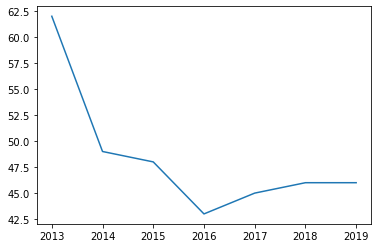

In [107]:
dataset['GII']['Russian Federation'].plot()

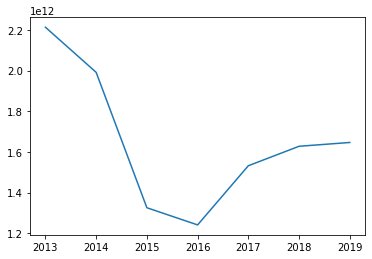

In [282]:
dataset['GNI']['Russian Federation'].plot()

In [242]:
#код составляет список номеров подъиндексов которые есть во всех годах
list_temp = list(dataset['2013']['2013'])

for k in range(len(list(dataset.keys())[0:7])):
    num_key1 = list(dataset.keys())[k]
    list_temp = set(list_temp).intersection(list(dataset[list(dataset.keys())[k]].iloc[:,0]))
    #interSubInd_list = list_temp
interSubInd_list = list(list_temp)
print('Количество подъиндексов, которые есть во всех годах:', len(interSubInd_list))

Количество подъиндексов, которые есть во всех годах: 34


In [281]:
y1 = '2018'
y2 = '2019'
sInd = {}
for subInd in interSubInd_list:
    #dataset['2013'].loc[dataset['2013']['2013']['Russian Federation']
    sInd[subInd] = dataset[y2].loc[dataset[y2][y2] == subInd]['Russian Federation'].item() - dataset[y1].loc[dataset[y1][y1] == subInd]['Russian Federation'].item()
    #print(subInd, ':', sInd)
sInd

{'2.2.1.': 4.0,
 '1.2.3.': 5.0,
 '4.2.1.': 4.0,
 '4.1.1.': -6.0,
 '4.3.2.': -18.0,
 '4.2.4.': 6.0,
 '1.3.2.': 0.0,
 '1.1.2.': -11.0,
 '2.1.2.': 0.0,
 '2.3.1.': 5.0,
 '6.1.2.': 1.0,
 '5.2.5.': 4.0,
 '3.1.3.': -12.0,
 '2.1.5.': -1.0,
 '3.2.3.': 35.0,
 '2.2.2.': -5.0,
 '4.1.3.': -2.0,
 '5.2.4.': 4.0,
 '5.1.2.': 1.0,
 '2.1.1.': 1.0,
 '5.3.4.': -1.0,
 '5.2.1.': -1.0,
 '1.2.2.': 1.0,
 '1.2.1.': 7.0,
 '4.1.2.': 1.0,
 '5.2.3.': 4.0,
 '3.2.1.': 1.0,
 '6.3.4.': 1.0,
 '1.3.1.': 4.0,
 '3.3.2.': 0.0,
 '5.2.2.': 10.0,
 '1.1.1.': -14.0,
 '2.3.2.': 0.0,
 '5.3.1.': 0.0}